In [20]:
import numpy as np
import matplotlib.pyplot as plt
import optuna
import sys
import os
import json

Loading the data

In [21]:
def load_tsp_file(file_path):
    tsp_data = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Flag to indicate the start of the NODE_COORD_SECTION
    start_loading = False

    for line in lines:
        # Strip leading and trailing whitespaces
        line = line.strip()

        # Check for the start of the NODE_COORD_SECTION
        if line == "NODE_COORD_SECTION":
            start_loading = True
            continue

        # Check for the end of the file
        if line == "EOF":
            break

        if start_loading:
            parts = line.split()
            
            # Extract node number, x-coordinate, and y-coordinate
            node_number = int(parts[0])
            x_coordinate = float(parts[1])
            y_coordinate = float(parts[2])

            # Store data in the dictionary
            tsp_data[node_number] = np.array([x_coordinate, y_coordinate])

    # Check if the dataset is as intuitive as it appears
    nodes = set(tsp_data.keys())
    highest_number = max(nodes)
    missing_nodes = set(range(1, highest_number + 1)) - nodes

    if missing_nodes:
        print(f"Note that not all numbers between 0 and {highest_number} are used as a node ID. Node(s) {missing_nodes} are missing.")

    return tsp_data

In [22]:
def custom_serialize(obj):
    """
    Returns the name of a function
    """
    if callable(obj):
        return obj.__name__
    return obj

def custom_deserialize(obj):
    """
    Returns the function corresponding to the function name provided
    """
    if '__name__' in obj:
        return globals()[obj]
    return obj


Generate random initial solution

In [23]:
def generate_solution(tsp_data):
    # Make random order as a starting solution
    return np.random.permutation(list(tsp_data.keys()))


def generate_greedy_solution(tsp_data, distance_matrix):
    # Initialize an empty route
    route = []
    
    # Start at the first city
    current_city = list(tsp_data.keys())[0]
    route.append(current_city)
    
    # Create a mask to keep track of visited cities
    visited_mask = np.zeros(len(tsp_data), dtype=bool)
    visited_mask[current_city - 1] = True
    
    # Continue searching for the next neighbor until all cities are visited
    while len(route) < len(tsp_data):
        # Get the index of the current city
        current_index = current_city - 1
        
        # Get the row of distances for the current city
        distances = distance_matrix[current_index]
        
        # Apply the visited mask to exclude already visited cities
        distances[visited_mask] = np.inf
        
        # Find the unvisited neighbor with the minimum distance
        next_city = np.argmin(distances) + 1
        
        # Add the next city to the route
        route.append(next_city)
        
        # Mark the next city as visited
        visited_mask[next_city - 1] = True
        
        # Move to the next city
        current_city = next_city
    
    return np.array(route)

Calculate score

In [24]:
def calculate_distance_matrix(tsp_data):
    coordinates = np.array(list(tsp_data.values()))
    distance_matrix = np.linalg.norm(coordinates[:, np.newaxis, :] - coordinates[np.newaxis, :, :], axis=-1)
    
    return distance_matrix

In [25]:
def get_score(distance_matrix, solution):
    # Calculate distance of a solution using the precomputed distance matrix
    from_cities = np.array(solution[:-1]) - 1
    to_cities = np.array(solution[1:]) - 1
    
    total_distance = np.sum(distance_matrix[from_cities, to_cities])
    
    return total_distance

Mutation operators

In [26]:
def swap(solution, iteration):
    # Randomly choose two distinct indices
    indices = np.random.choice(len(solution), size=2, replace=False)

    new_solution = solution.copy()

    # Swap the elements at the selected indices
    new_solution[indices[0]], new_solution[indices[1]] = new_solution[indices[1]], new_solution[indices[0]]

    return new_solution


def inversion(solution, iteration):
    n = len(solution)

    # Choose two distinct indices for the inversion
    start, end = np.random.choice(n, size=2, replace=False)
    start, end = min(start, end), max(start, end)

    # Perform inversion
    new_solution = solution.copy()
    new_solution[start:end + 1] = np.flip(new_solution[start:end + 1])

    return new_solution


def insert(solution, iteration):
    n = len(solution)

    # Choose two distinct indices for the insertion
    source_index, dest_index = np.random.choice(n, size=2, replace=False)

    # Ensure source_index is before dest_index
    source_index, dest_index = min(source_index, dest_index), max(source_index, dest_index)

    # Perform insertion
    moved_element = solution[source_index]
    new_solution = np.delete(solution, source_index)
    new_solution = np.insert(new_solution, dest_index, moved_element)

    return new_solution


def two_opt(solution, iteration):
    """ Given a TSP route called solution and the current iteration of the algorithm,
    switches the next possible pair of nodes and returns the corresponding route """

    # Get number of nodes
    n = len(solution)

    # Get the number of total pairs
    total_pairs = int(n * (n-1) / 2)

    # Get index of current pair of nodes to consider
    start =  (iteration % total_pairs) // (n-1)
    end =  (iteration % total_pairs) % (n-1)

    start, end = min(start, end), max(start, end)

    new_solution = solution.copy()
    new_solution[start:end + 1] = np.flip(new_solution[start:end + 1])

    # Return the new route
    return new_solution



# Didn't work properly so changed it to function above
def old_two_opt(solution, iteration):
    """ Given a TSP route called solution and the current iteration of the algorithm,
    switches the next possible pair of nodes and returns the corresponding route """

    # Get number of nodes
    n = len(solution)

    # Get the number of total pairs
    total_pairs = int(n * (n-1) / 2)

    # Get index of current pair of nodes to consider
    index_1 =  (iteration % total_pairs) // (n-1)
    index_2 =  (iteration % total_pairs) % (n-1)

    # Adjust index_2 if it is equal to or greater than index_1
    if index_2 >= index_1:
        index_2 += 1

    # Get current pair to swap
    node_1 = solution[index_1]
    node_2 = solution[index_2]

    # Invert the route between them
    a = solution[0:node_1+1]
    b = solution[node_1+1:node_2+1]
    b = b[::-1]
    c = solution[node_2+1:]
    new_solution = np.concatenate([a,b,c])

    # Return the new route
    return new_solution

Acceptance operators

In [27]:
def hillclimber(current_score, new_score, T):
    # Hillclimber function, accept only better scores
    return current_score > new_score

def simulated_annealing(current_score, new_score, T):
    return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)

Cooling schemes

In [28]:
def logarithmic_cool(iterations, cooling_parameters):
    i = np.arange(iterations) + 1
    return cooling_parameters['c'] / np.log(1 + i)


def linear_cool(iterations, cooling_parameters):
    i = np.arange(iterations)
    Ts = cooling_parameters['initial'] - cooling_parameters['slope'] * i
    return np.where(Ts < 0, 0, Ts)


def arithmetic_geometric_cool(iterations, cooling_parameters):
    T = cooling_parameters['initial']
    Ts = np.zeros(iterations)

    for i in range(iterations):
        T = T * cooling_parameters['alpha'] + cooling_parameters['beta']
        Ts[i] = T
    
    return Ts


def exponential_cool(iterations, cooling_parameters):
    i = np.arange(iterations)
    return cooling_parameters['initial'] * cooling_parameters['alpha']**i


def quadratic_cool(iterations, cooling_parameters):
    i = np.arange(iterations)
    return cooling_parameters['initial'] / (1 + cooling_parameters['alpha'] * i**2)

Main optimizing function

In [29]:
def optimize(start_solution, distance_matrix, iterations, mutate, accept, cooling_schedule=logarithmic_cool, cooling_parameters={'c':1}, stopping_point=0.05, save_progress=False):
    """
    Optimize solution for traveling salesman problem according to chosen mutate and accept function
    """ 

    solution = start_solution[:]
    current_score = get_score(distance_matrix, solution)

    Ts = cooling_schedule(iterations, cooling_parameters)

    iterations_without_improvement = 0
    stopping_point *= iterations

    scores = {}

    # Do iterations
    for i in range(iterations):

        # Make new solution via chosen mutation function
        new_solution = mutate(solution, i)
        new_score = get_score(distance_matrix, new_solution)

        # Accept or deny new solution according to chosen acceptance function and corresponding parameters
        if accept(current_score, new_score, Ts[i]):
            solution = new_solution[:]
            current_score = new_score
            iterations_without_improvement = 0

            if save_progress:
                scores[i] = new_score
            
        else:
            iterations_without_improvement += 1
            if iterations_without_improvement == stopping_point:
                return solution, current_score, scores

    return solution, current_score, scores

Tuning functions for cooling schemes

In [30]:
def tune_logarithmic_cool(trial, tsp_data, distance_matrix, runs, iterations, mutate, accept, greedy=True):
    c = trial.suggest_float('c', 0.001, 1000)
    result = 0
    for run in range(runs):
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
        else:
            start_solution = generate_solution(tsp_data)
        result += optimize(start_solution, distance_matrix, iterations, mutate, accept, logarithmic_cool, {'c': c})[1] / runs
        
    return result

def tune_linear_cool(trial, tsp_data, distance_matrix, runs, iterations, mutate, accept, greedy=True):
    initial = trial.suggest_float('initial', 0.01, 10000)
    slope = trial.suggest_float('slope', 0., 10)
    result = 0
    for run in range(runs):
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
        else:
            start_solution = generate_solution(tsp_data)
        result += optimize(start_solution, distance_matrix, iterations, mutate, accept, linear_cool, {'initial': initial, 'slope': slope})[1] / runs
        
    return result

def tune_arithmetic_geometric_cool(trial, tsp_data, distance_matrix, runs, iterations, mutate, accept, greedy=True):
    initial = trial.suggest_float('initial', 0.001, 10000)
    alpha = trial.suggest_float('alpha', 0., 1)
    beta = trial.suggest_float('beta', 0., 100)

    result = 0
    for run in range(runs):
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
        else:
            start_solution = generate_solution(tsp_data)
        result += optimize(start_solution, distance_matrix, iterations, mutate, accept, arithmetic_geometric_cool, {'initial': initial, 'alpha': alpha, 'beta': beta})[1] / runs
        
    return result

def tune_exponential_cool(trial, tsp_data, distance_matrix, runs, iterations, mutate, accept, greedy=True):
    initial = trial.suggest_float('initial', 0.001, 1000)
    alpha = trial.suggest_float('alpha', 0., 1)
    result = 0
    for run in range(runs):
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
        else:
            start_solution = generate_solution(tsp_data)
        result += optimize(start_solution, distance_matrix, iterations, mutate, accept, exponential_cool, {'initial': initial, 'alpha': alpha})[1] / runs
        
    return result

def tune_quadratic_cool(trial, tsp_data, distance_matrix, runs, iterations, mutate, accept, greedy=True):
    initial = trial.suggest_float('initial', 0.001, 10000)
    alpha = trial.suggest_float('alpha', 0., 1)
    result = 0
    for run in range(runs):
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
        else:
            start_solution = generate_solution(tsp_data)
        result += optimize(start_solution, distance_matrix, iterations, mutate, accept, quadratic_cool, {'initial': initial, 'alpha': alpha})[1] / runs
        
    return result

Main tuning function

In [31]:
def tune(tsp_data, distance_matrix, tuning_runs, n_trials, iterations, mutations, cooling_schedules, file_path=None, greedy=False):
    """
    Tunes parameters of all combinations of the provided cooling schedules and mutations for a set number of iterations, and stores them in as a JSON file
    """

    if file_path:
        if os.path.exists(file_path):
            print(f"Error: The file '{file_path}' already exists. Please choose a different file name.")
            sys.exit(1)
            
    accept = simulated_annealing
    print_status = False

    all_cooling_parameters = {}
    if not print_status:
        optuna.logging.set_verbosity(optuna.logging.WARNING)

    for mutate in mutations:
        cooling_parameters = {}

        for cooling_schedule in cooling_schedules:
            
            cooling_scheme = cooling_schedule.__name__
            study = optuna.create_study()
            study.optimize(lambda trial: globals()['tune_' + cooling_scheme](trial, tsp_data, distance_matrix, tuning_runs, iterations, mutate, accept, greedy=greedy), n_trials=n_trials)
            cooling_parameters[cooling_scheme] = {'cooling_schedule': cooling_schedule, 'cooling_parameters': study.best_params}

        all_cooling_parameters[mutate.__name__] = cooling_parameters
    
    if file_path:
        with open(file_path, 'w') as file:
            json.dump(all_cooling_parameters, file, default=custom_serialize, indent=2)

    return all_cooling_parameters


def global_tuning(files, iterations_list, cooling_schedules, mutations, tuning_runs, n_trials, greedy, fileID=''):
    """
    Runs the tuning function for all files and different amounts of iterations
    """
    for file in files:
        file_path = f'TSP-Configurations/{file}.tsp.txt'
        tsp_data = load_tsp_file(file_path)
        distance_matrix = calculate_distance_matrix(tsp_data)

        for iterations in iterations_list:
            tune(tsp_data, distance_matrix, tuning_runs, n_trials, iterations, mutations, cooling_schedules, file_path=f'{fileID}best_parameters_{file}_{iterations}_iterations.json', greedy=greedy)

In [32]:
def load_cooling_info(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file, object_hook=custom_deserialize)

    for item in data.values():
        for subitem in item.values():
            cooling = subitem['cooling_schedule']
            subitem['cooling_schedule'] = globals()[cooling]
    return data

Plot cooling behaviour. Didn't show what we hoped for so might just delete it

In [33]:
def investigate_cooling(iterations, cooling_schedule, cooling_parameters, title, percentage=None, difference=None, num_datapoints=None, ax=None, logx=False, logy=False):
    Ts = cooling_schedule(iterations, cooling_parameters)
    
    if num_datapoints is not None and num_datapoints > iterations:
        stride = max(1, iterations // num_datapoints)
    else:
        stride = 1

    if ax is None:
        fig, ax = plt.subplots()

    if percentage:
        differences = Ts * np.log(percentage)
        ax.plot(np.arange(iterations)[::stride], differences[::stride], label=f'{iterations} iterations')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Setback')
        ax.set_title(f"Setback which will be accepted with {percentage}% chance with {title}")


    elif difference:
        percentages = np.exp(-1 * abs(difference)/Ts)
        ax.plot(np.arange(iterations)[::stride], percentages[::stride], label=f'{iterations} iterations')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Acceptance probability')
        ax.set_title(f"Acceptance probabilities of {title} with a setback of {abs(difference)}")

    else:
        ax.plot(np.arange(iterations)[::stride], Ts[::stride], label=f'{iterations} iterations')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Temperature')
        ax.set_title(f"Temperature decrease of {title}")

    if logx:
        ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')

Compare performance of all different algorithm combinations with a given set of mutations and cooling schedules

In [45]:
def compare_algorithms(tsp_data, distance_matrix, all_cooling_parameters, N_runs, iterations, mutations, cooling_schedules, accept=simulated_annealing, plot_results=True, print_results=True, set_title=False, greedy=True):
    results = []
    for cooling_schedule in cooling_schedules:
        cooling_results = []
        
        for mutate in mutations:
            scores = []
            parameters = all_cooling_parameters[mutate.__name__][cooling_schedule.__name__]
            for run in range(N_runs):

                if greedy:
                    start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
                else:
                    start_solution = generate_solution(tsp_data)
                    
                score = optimize(start_solution, distance_matrix, iterations, mutate, accept, **parameters)[1]
                scores.append(score)

            cooling_results.append({'mutation function': mutate.__name__,'scores': scores , 'average': np.mean(scores), 'std': np.std(scores)})

        results.append({'cooling schedule': cooling_schedule.__name__, 'data': cooling_results})
    

    if not(print_results or plot_results):
        return results

    bar_width = 0.1
    bar_positions = np.arange(len(mutations))
    mutation_names = [func.__name__ for func in mutations]
    cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling','Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']


    for i, result in enumerate(results):
        if print_results:
            print(f"\n\n{cooling_schemes[i]}:\n")
            print("%-40s %-20s" % ("Mutation Function", "Results"))

        if plot_results:
            bar_results = []
            bar_stds = []

        for data in result['data']:
            average = data['average']
            std = data['std']

            if plot_results:
                bar_results.append(average)
                bar_stds.append(std)

            if print_results:
                mutation_function = data['mutation function']
                score_with_std = "%.4f (+/- %.4f)" % (average, std)
                print("%-40s %-15s" % (mutation_function, score_with_std))
        if plot_results:
            plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, label=cooling_schemes[i], align='center')

    if plot_results:
        title_addition = ''
        if set_title:
            title_addition = f' with {iterations} iterations'
        plt.xlabel('Mutation Functions')
        plt.ylabel('Scores')
        plt.title(f'Performance of all algorithm combinations{title_addition}')
        plt.xticks(bar_positions + bar_width * (len(cooling_schemes) - 1) / 2, mutation_names)
        plt.grid()
        # plt.legend()

        plt.tight_layout()
        plt.show()

    # NEW!
    return results


Load the best parameters from the json files where the tuning stored them, for all different numbers of iterations, and compare the performance of all given algorithm combinations. 

In [46]:
def compare_all_algorithms_old(tsp_data, distance_matrix, file, N_runs, iterations_list, greedy=True, fileID=''):
    for iterations in iterations_list:
        all_cooling_parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')

        mutations = list(all_cooling_parameters.keys())
        cooling_schedules = list(all_cooling_parameters[mutations[0]].keys())
        
        mutations = [globals()[mutation] for mutation in mutations]
        cooling_schedules = [globals()[cooling_schedule] for cooling_schedule in cooling_schedules]

        results = compare_algorithms(tsp_data, distance_matrix, all_cooling_parameters, N_runs, iterations, mutations, cooling_schedules, print_results=False, set_title=True, greedy=greedy)

# Update function to return all results!
def compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, greedy=True, fileID=''):
    results = []
    for iterations in iterations_list:
        all_cooling_parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')

        mutations = list(all_cooling_parameters.keys())
        cooling_schedules = list(all_cooling_parameters[mutations[0]].keys())
        
        mutations = [globals()[mutation] for mutation in mutations]
        cooling_schedules = [globals()[cooling_schedule] for cooling_schedule in cooling_schedules]

        result = compare_algorithms(tsp_data, distance_matrix, all_cooling_parameters, N_runs, iterations, mutations, cooling_schedules, print_results=False, set_title=True, greedy=greedy)
        results.append(result)
    
    return results


    # fig, ax = plt.subplots()

    # im = ax.imshow(data, cmap='viridis', interpolation='nearest')

    # x_gridlines = np.arange(-0.5, 19.5, 5)
    # y_gridlines = np.arange(-0.5, 6.5)

    # for x in x_gridlines:
    #     ax.axvline(x=x, color='black', linestyle='-', linewidth=3)

    # for y in y_gridlines:
    #     ax.axhline(y=y, color='black', linestyle='-', linewidth=3)

    # xlabels = ['Swap', 'Insert', 'Inversion', '2-opt']
    # ax.set_xticks(x_gridlines + 2.5)
    # ax.set_xticklabels(xlabels, fontsize=8)
    # ax.tick_params(axis='x', which='major', pad=-115)

    # additional_xticks = np.arange(1, 21) - 0.9
    # additional_labels = ['Logarithmic', 'Linear', 'Arithmetic-Geometric', 'Exponential', 'Quadratic'] * 4
    # ax.set_xticks(additional_xticks, minor=True)
    # ax.set_xticklabels(additional_labels, rotation=75, minor=True, fontsize=8)


    # ylabels = ['10000', '5000', '1000', '500', '100', '50', '10']
    # ax.set_yticks(y_gridlines + 0.5, ylabels)

    # cbar = plt.colorbar(im, ax=ax)
    # cbar.set_label('Score')

    # plt.xlabel('Algorithm')
    # plt.ylabel('Iterations')

    # plt.show()

In [231]:
def investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, cooling_parameters=None, desired_std=-1, greedy=False, stopping_point=0.05):
    if not cooling_parameters:
        try:
            parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')
            cooling_parameters = parameters[mutate.__name__][cooling_schedule.__name__]['cooling_parameters']
        except:
            print(f'Tuning has not been done for {cooling_schedule.__name__} in combination with {mutate.__name__} for the {file} dataset with {iterations} iterations.')
            print(f"So, function needs to be called with parameters")
            return
    
    
    file_path = f'TSP-Configurations/{file}.tsp.txt'
    tsp_data = load_tsp_file(file_path)

    distance_matrix = calculate_distance_matrix(tsp_data)

    accept = simulated_annealing

    # parameters = {
    #     'initial': 50,
    #     'slope': 0.0005,
    # }

    # iterations = 10000000


    # Do first run
    if greedy:
        start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
    else:
        start_solution = generate_solution(tsp_data)

    solution, score, scores = optimize(start_solution, distance_matrix, iterations, mutate, accept, cooling_schedule, cooling_parameters, stopping_point=stopping_point, save_progress=True)

    event_iterations = list(scores.keys())
    new_scores = list(scores.values())

    if not event_iterations:
        progress_results = [np.interp(np.arange(iterations), [0, iterations], [score, score])]
    else:
        progress_results = [np.interp(np.arange(iterations), event_iterations, new_scores)]

    score_results = [score]

    # Do second run
    if N_runs > 1:
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
        else:
            start_solution = generate_solution(tsp_data)

        solution, score, scores = optimize(start_solution, distance_matrix, iterations, mutate, accept, cooling_schedule, cooling_parameters, stopping_point=stopping_point, save_progress=True)

        event_iterations = list(scores.keys())
        new_scores = list(scores.values())

        if not event_iterations:
            progress_results.append(np.interp(np.arange(iterations), [0, iterations], [score, score]))
        else:
            progress_results.append(np.interp(np.arange(iterations), event_iterations, new_scores))

        score_results.append(score)

        current_run = 2

        # Continue running until stopping criteria are reached
        while (current_run < N_runs and (np.std(score_results) / np.sqrt(current_run) > desired_std)):
            if greedy:
                start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
            else:
                start_solution = generate_solution(tsp_data)

            solution, score, scores = optimize(start_solution, distance_matrix, iterations, mutate, accept, cooling_schedule, cooling_parameters, stopping_point=stopping_point, save_progress=True)

            event_iterations = list(scores.keys())
            new_scores = list(scores.values())

            if not event_iterations:
                progress_results.append(np.interp(np.arange(iterations), [0, iterations], [score, score]))
            else:
                progress_results.append(np.interp(np.arange(iterations), event_iterations, new_scores))

            score_results.append(score)
            current_run += 1

        scores = np.mean(progress_results, axis=0)
        #plt.plot(np.arange(iterations), scores, linestyle='-', color='b')
        
        errors = np.std(progress_results, axis=0)
        #plt.fill_between(np.arange(iterations), scores - errors, scores + errors, alpha=0.7)

    
    scores = np.mean(progress_results, axis=0)

    return scores, errors

    plt.plot(np.arange(iterations), scores, linestyle='-', color='r')

    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.title('Score Progress Over Time')

    plt.show()

    print(f"Runs done: {N_runs}")
    print(f"Cooling scheme {cooling_schedule.__name__} with parameters: {cooling_parameters}")
    print(f"Mutation: {mutate.__name__}")
    if N_runs == 1:
        print(f"Score: {score}")
    else:
        print(f"Average result: {np.mean(score_results)} +/- {np.std(score_results) / np.sqrt(current_run)}")
        print(f"Best score: {min(score_results)}")



Open a file, and tune the parameters for all different algorithm combinations.

Be advised, might take a while!

In [37]:
files = ['eil51', 'a280', 'pcb442']
cooling_schedules = [logarithmic_cool, linear_cool, arithmetic_geometric_cool, exponential_cool, quadratic_cool]
mutations = [swap, insert, inversion, two_opt]
fileID = 'random_'

iterations_list = [5000, 10000]
tuning_runs = 5
n_trials = 100

# global_tuning(files, iterations_list, cooling_schedules, mutations, tuning_runs, n_trials, greedy=False, fileID=fileID)

Compare results of the global tuning just done

C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


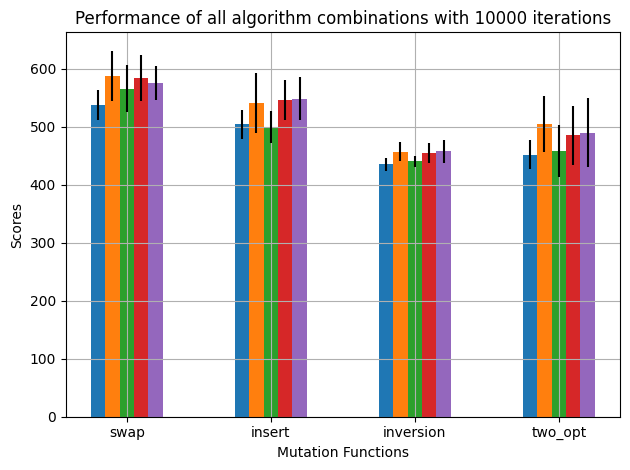

In [58]:
N_runs = 20
file = 'eil51'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

#iterations_list = [5000, 10000]
iterations_list = [10000]
#compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, greedy=False, fileID=fileID)
results = compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, greedy=False, fileID=fileID)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


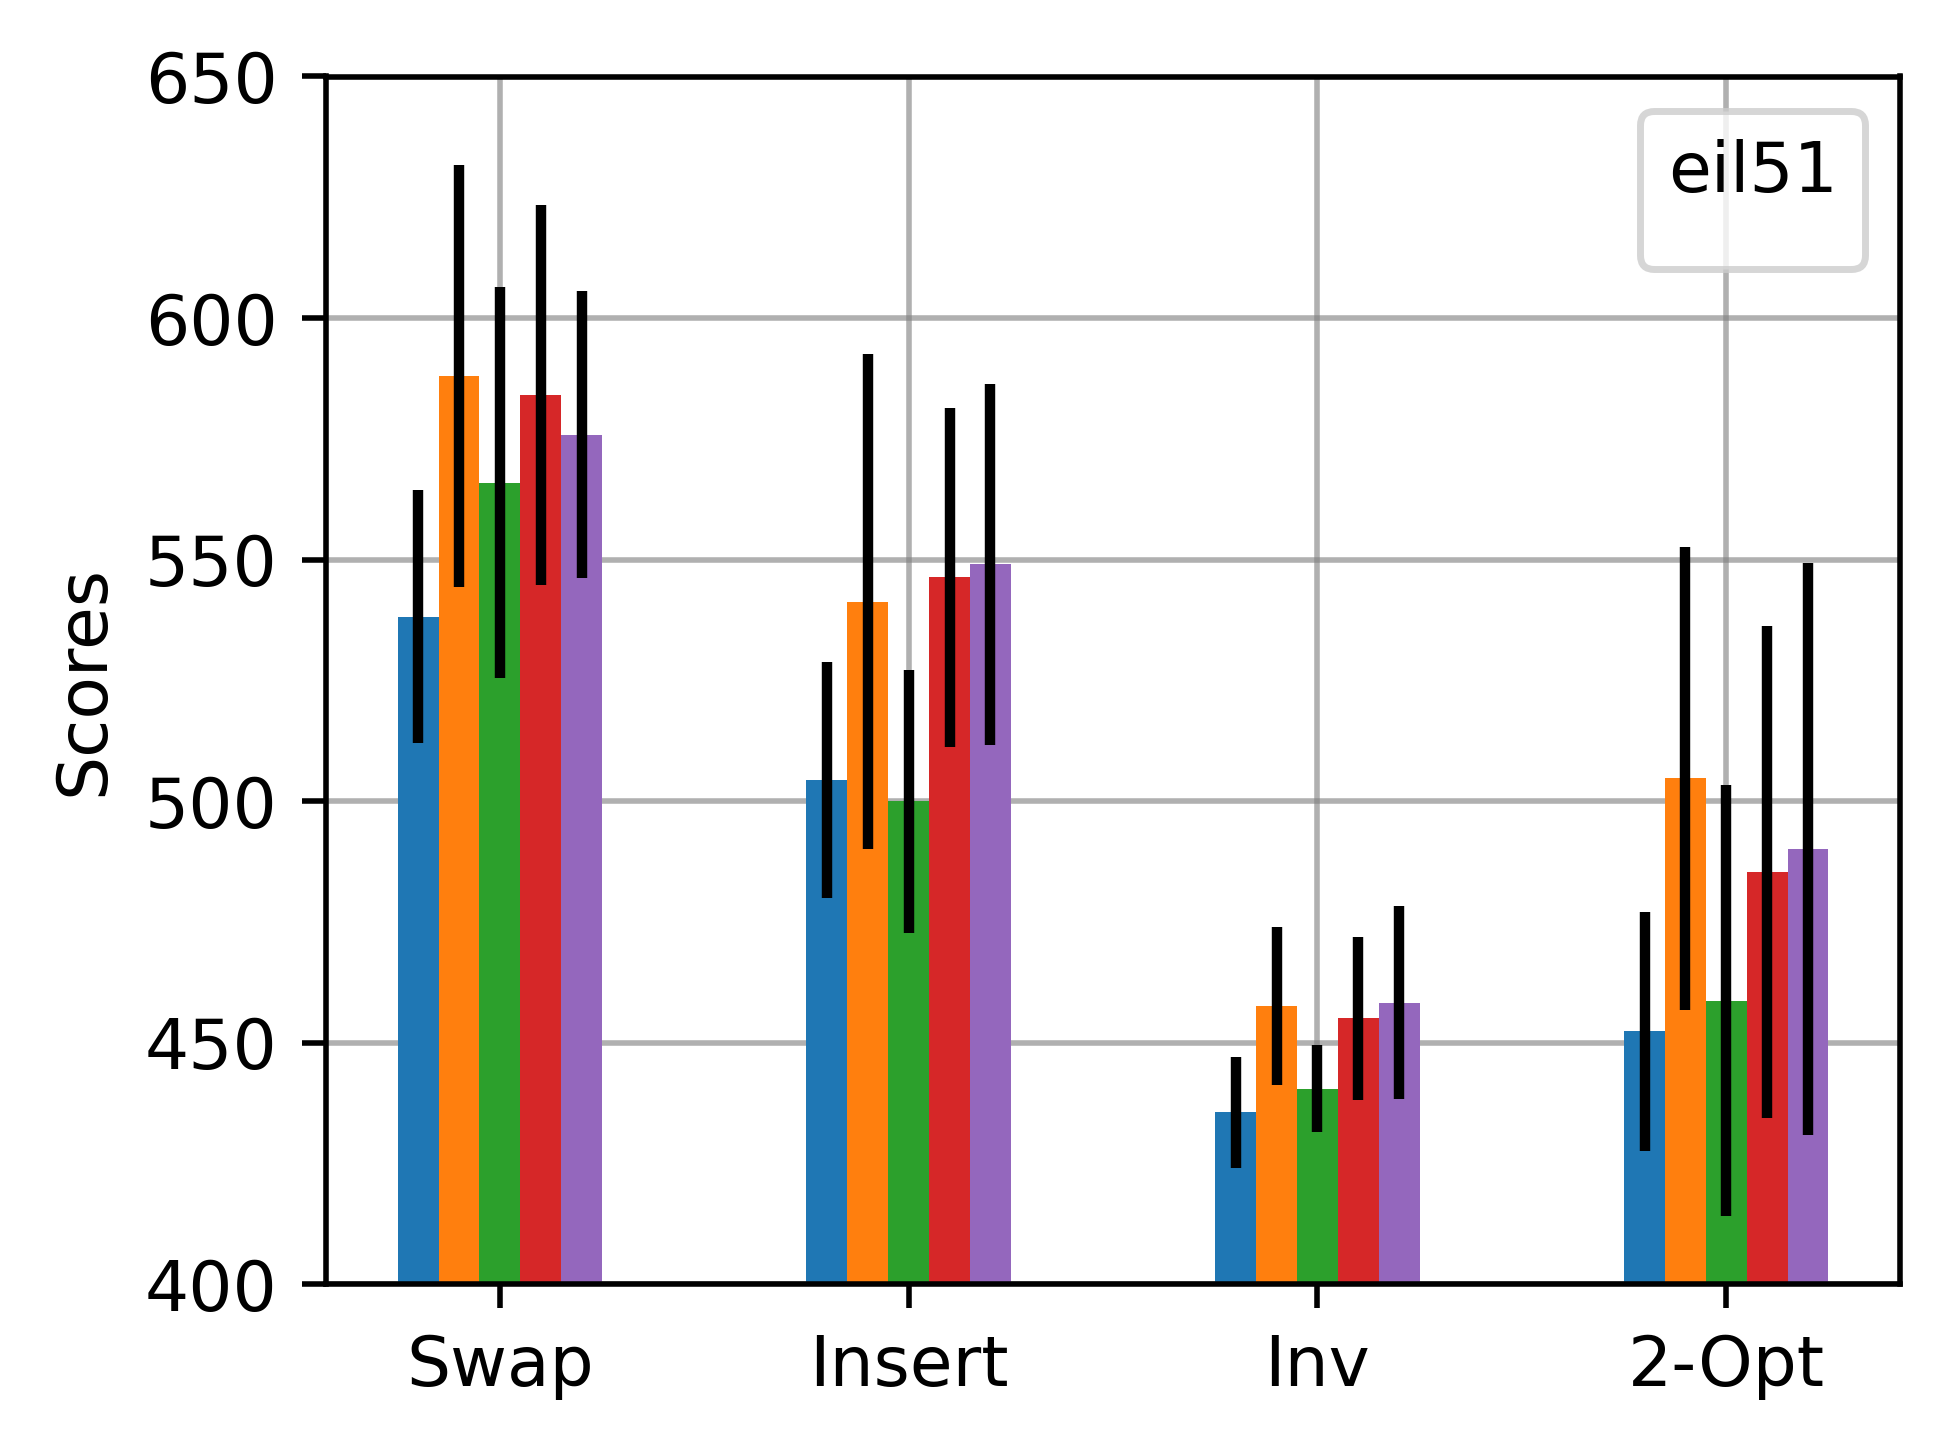

In [190]:
# UPDATED PLOTS
plt.figure(figsize=(4,3),dpi=500)

bar_width = 0.1
bar_positions = np.arange(len(mutations))
mutation_names = [func.__name__.title() for func in mutations]
mutation_names[2] = 'inv'.title()
mutation_names[3] = '2-Opt'
cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling','Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']

res = results[0]
for i, sched in enumerate(res):
    bar_results = []
    bar_stds = []

    for data in sched['data']:
        average = data['average']
        std = data['std']
        bar_results.append(average)
        bar_stds.append(std)

    #plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, label=cooling_schemes[i], zorder=2,align='center',alpha=1)
    plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, zorder=2,align='center',alpha=1)



plt.ylabel('Scores')
plt.xticks(bar_positions + bar_width * (len(cooling_schemes) - 1) / 2, mutation_names)
plt.grid(color='gray', linestyle='-',zorder=0,alpha=0.618)
plt.ylim([400,650])


plt.legend()
plt.legend(title='eil51')


plt.tight_layout()
plt.savefig('tuning_51_random.png')
plt.show()

In [107]:
# UPDATED PLOTS
# DONT TOUCH RESULTS
res = results
print(results)

#result = results[0][0]

bar_results = []
bar_stds = []


print_results = True
plot_results = True
iterations = 10000
set_title = False


bar_width = 0.1
bar_positions = np.arange(len(mutations))
mutation_names = [func.__name__ for func in mutations]
cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling','Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']

for i, result in enumerate(results):
    print(i,result[0])

for i, result in enumerate(results):
    print(i,result)
    #if print_results:
    #    print(f"\n\n{cooling_schemes[i]}:\n")
    #    print("%-40s %-20s" % ("Mutation Function", "Results"))

    if plot_results:
        bar_results = []
        bar_stds = []

    for data in result['data']:
        average = data['average']
        std = data['std']

        if plot_results:
            bar_results.append(average)
            bar_stds.append(std)

        #if print_results:
        #    mutation_function = data['mutation function']
        #    score_with_std = "%.4f (+/- %.4f)" % (average, std)
        #    print("%-40s %-15s" % (mutation_function, score_with_std))
    if plot_results:
        plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, label=cooling_schemes[i], align='center')

    print('next')

if plot_results:
    title_addition = ''
    if set_title:
        title_addition = f' with {iterations} iterations'
    plt.xlabel('Mutation Functions')
    plt.ylabel('Scores')
    plt.title(f'Performance of all algorithm combinations{title_addition}')
    plt.xticks(bar_positions + bar_width * (len(cooling_schemes) - 1) / 2, mutation_names)
    plt.grid()
    # plt.legend()

    plt.tight_layout()
    plt.show()
# PLOT IN POINTS? -> 10000 it only

[[{'cooling schedule': 'logarithmic_cool', 'data': [{'mutation function': 'swap', 'scores': [590.7812052713562, 558.545457658418, 525.3668866132382, 550.0832763381235, 494.5953326548538, 541.3900990807862, 573.7504634781747, 570.9095927270079, 491.64680571052037, 541.2088972471579, 544.1730196767559, 505.92739607100907, 555.4594991506129, 541.9498669948869, 527.7721587116858, 535.5099377299741, 514.0771215281803, 550.7686257714872, 500.9150358374978, 549.2094466092192], 'average': 538.2020062430472, 'std': 26.13671548360194}, {'mutation function': 'insert', 'scores': [513.4643196924568, 472.67631676691593, 526.4660616126963, 505.91750814088095, 537.8063004025072, 476.08285480645515, 493.1091716515594, 478.4756569065683, 531.5770499658254, 491.2679228421147, 496.0552731503774, 530.4198555986286, 523.1701679244189, 533.7613759916205, 466.38572770647295, 497.4525298415487, 517.5250561476414, 536.1224607997377, 459.40020190264846, 499.862756941076], 'average': 504.34992843960754, 'std': 24

TypeError: list indices must be integers or slices, not str

C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


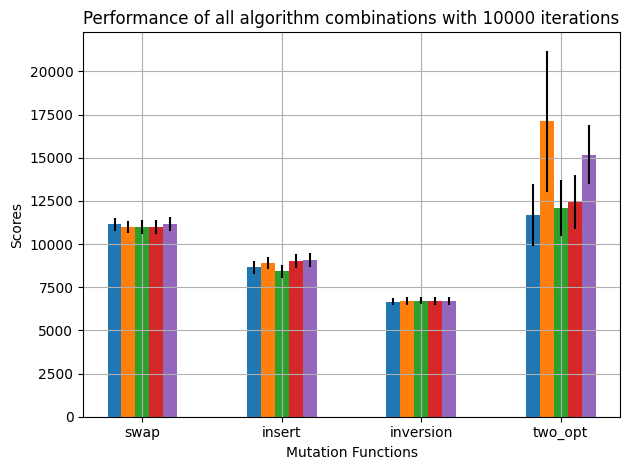

In [191]:
N_runs = 20
file = 'a280'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [10000]
results = compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, greedy=False, fileID=fileID)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


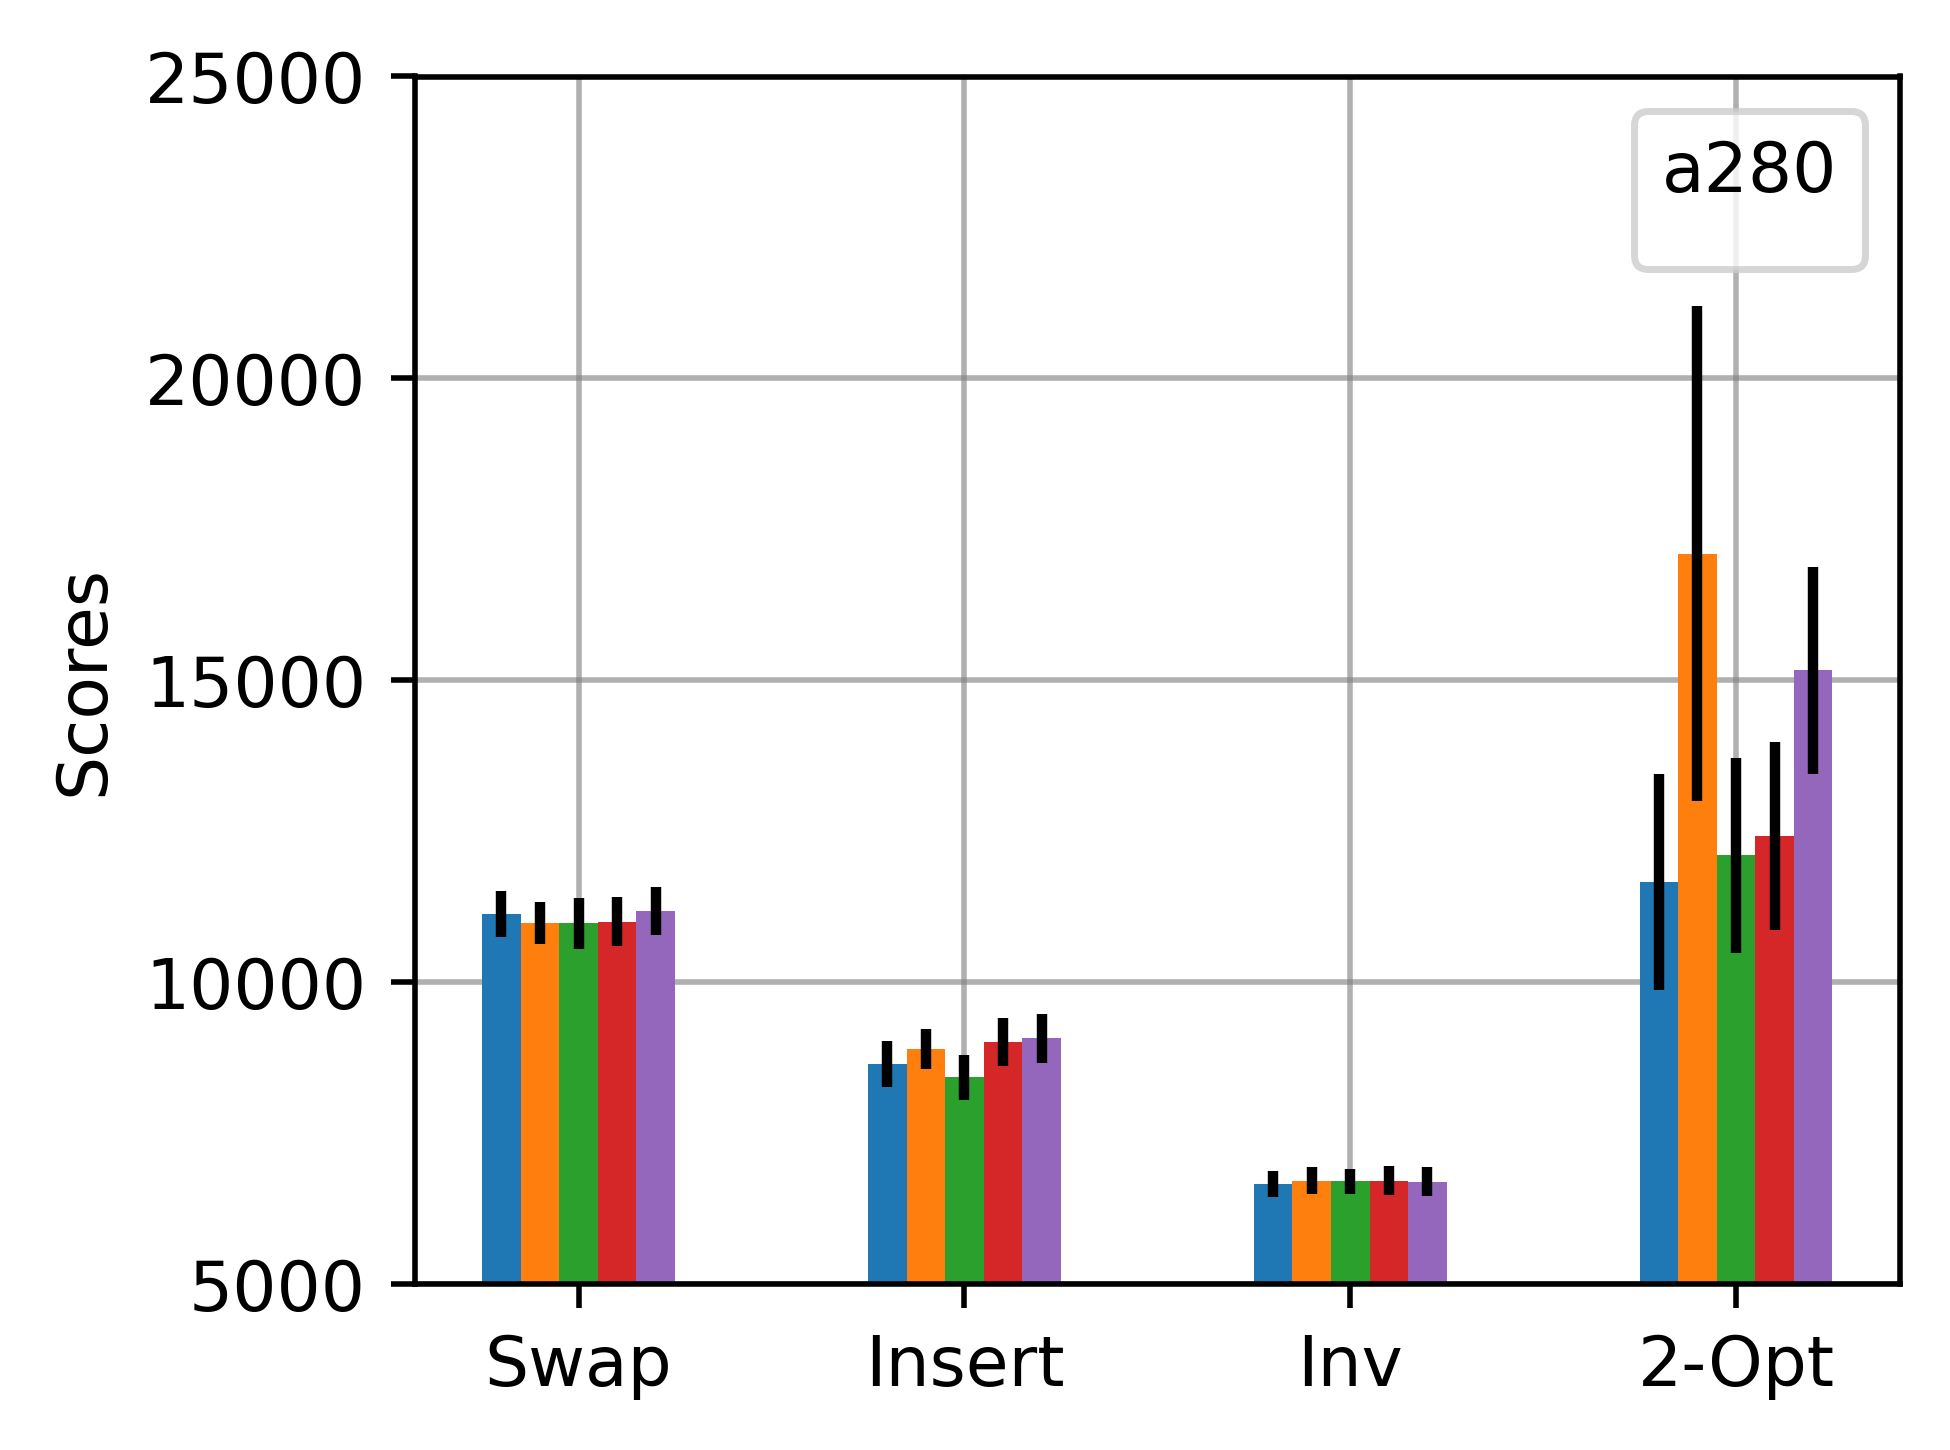

In [198]:
# Plot
# UPDATED PLOTS
plt.figure(figsize=(4,3),dpi=500)

bar_width = 0.1
bar_positions = np.arange(len(mutations))
mutation_names = [func.__name__.title() for func in mutations]
mutation_names[2] = 'inv'.title()
mutation_names[3] = '2-Opt'
cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling','Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']

res = results[0]
for i, sched in enumerate(res):
    bar_results = []
    bar_stds = []

    for data in sched['data']:
        average = data['average']
        std = data['std']
        bar_results.append(average)
        bar_stds.append(std)

    #plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, label=cooling_schemes[i], zorder=2,align='center',alpha=1)
    plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, zorder=2,align='center',alpha=1)



plt.ylabel('Scores')
plt.xticks(bar_positions + bar_width * (len(cooling_schemes) - 1) / 2, mutation_names)
plt.grid(color='gray', linestyle='-',zorder=0,alpha=0.618)
plt.yticks(np.linspace(5000,25000,5))
plt.ylim([5000,25000])


plt.legend(title='a280',loc='upper right')


plt.tight_layout()
plt.savefig('tuning_280_random.png')
plt.show()

C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


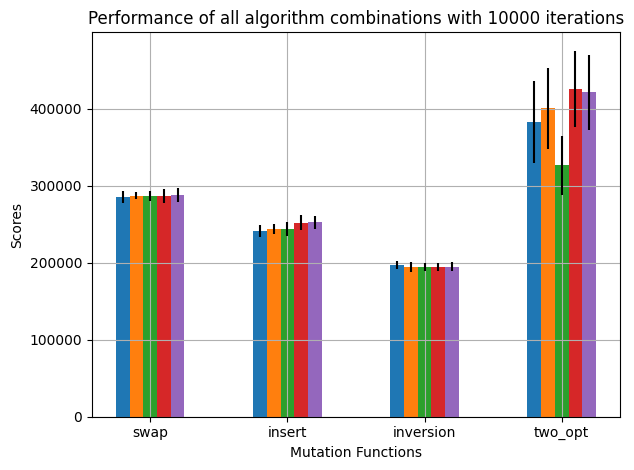

In [199]:
N_runs = 20
file = 'pcb442'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [10000]
results = compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, greedy=False, fileID=fileID)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


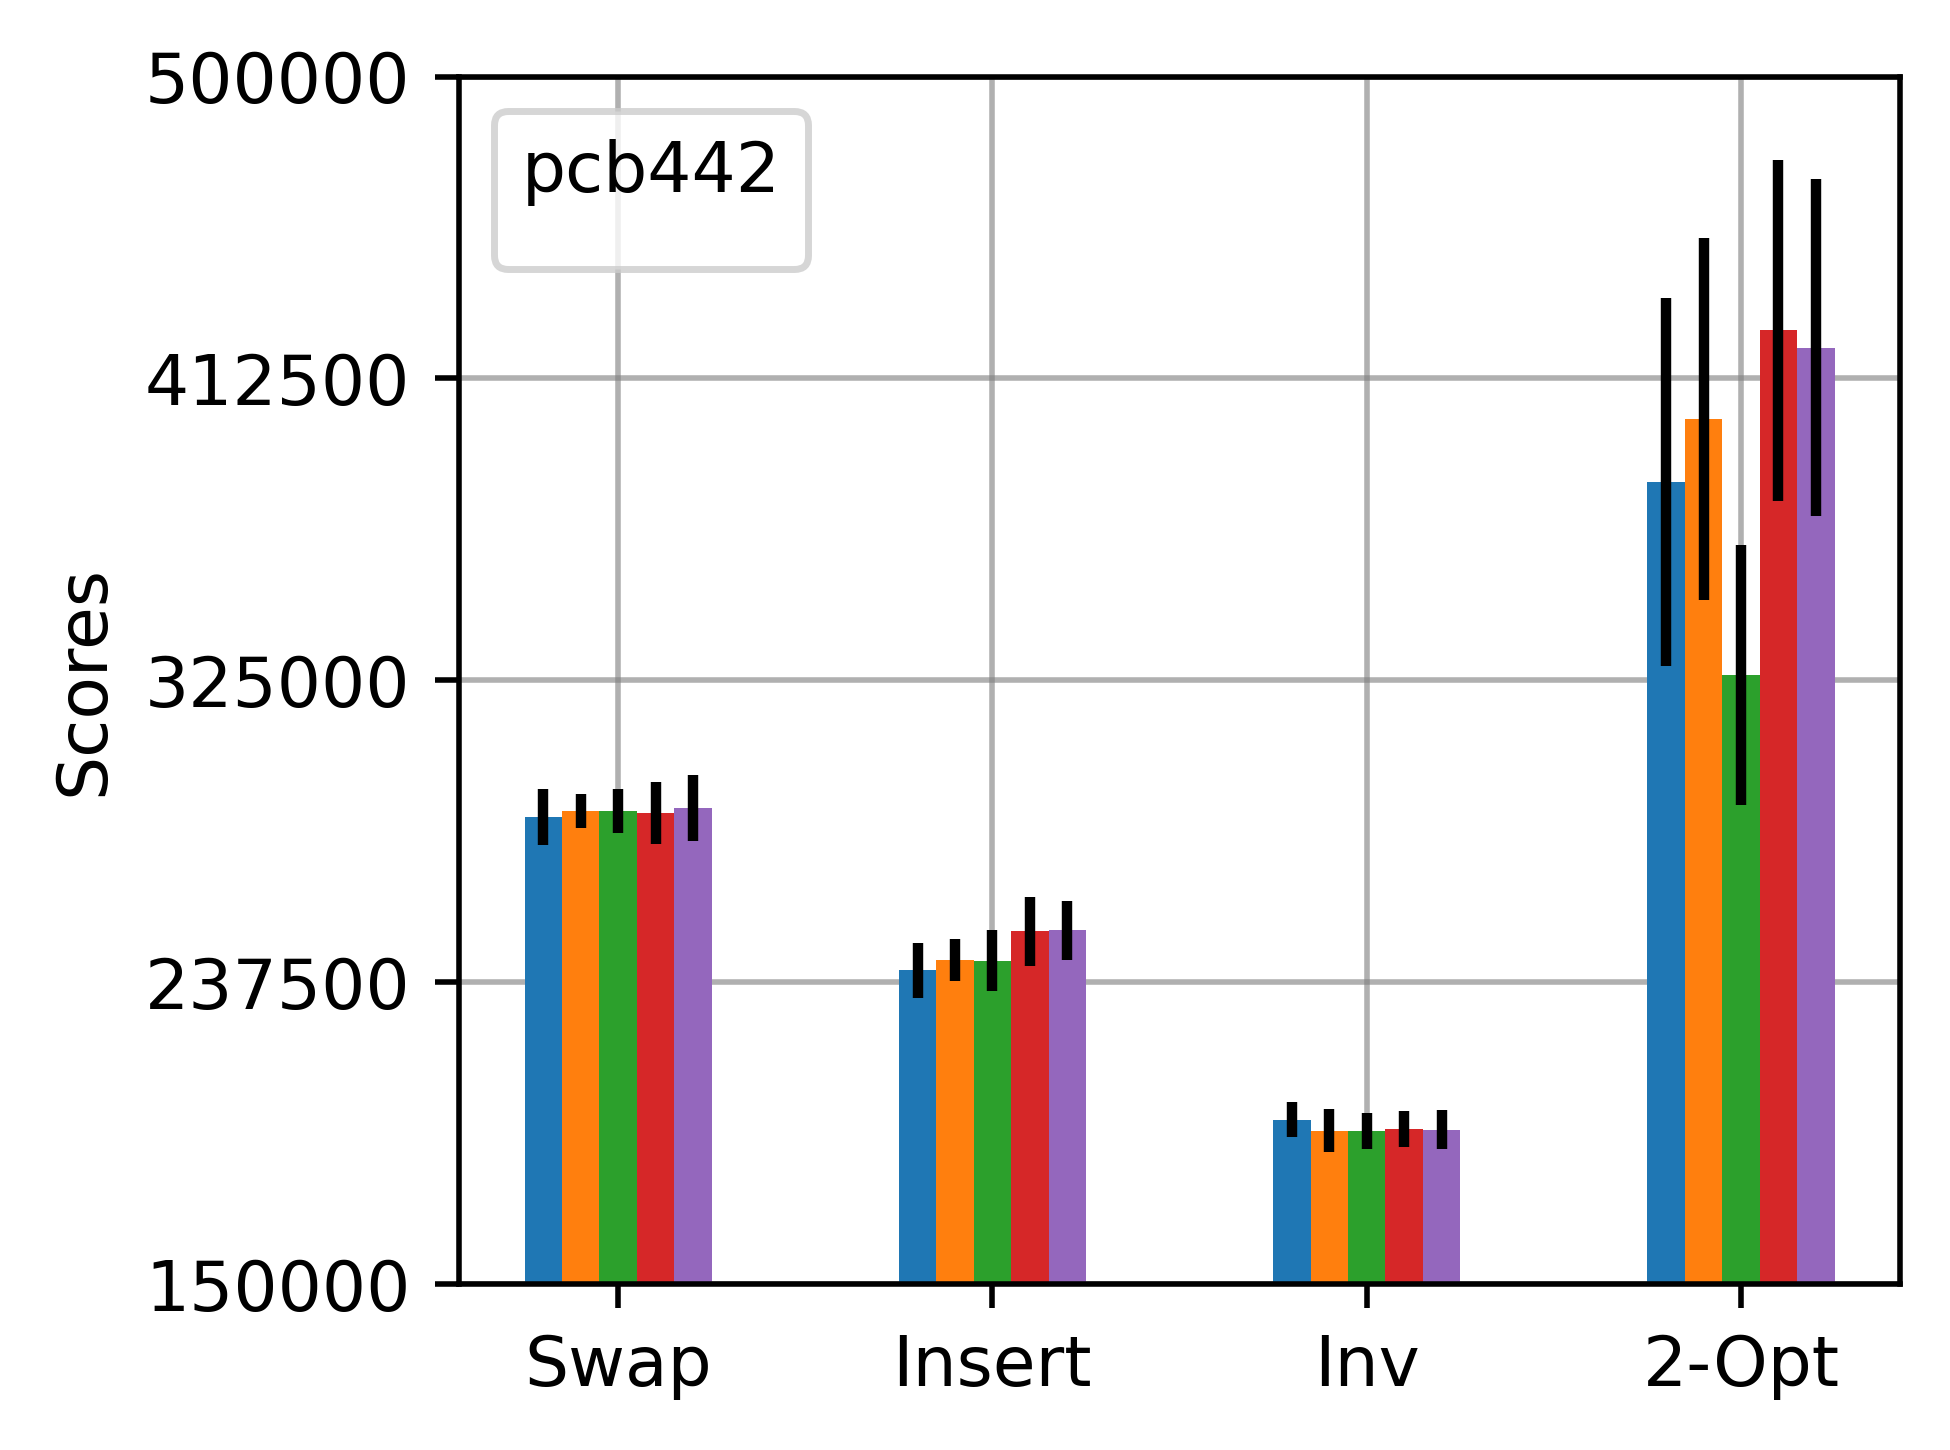

In [204]:
# Plot
# UPDATED PLOTS
plt.figure(figsize=(4,3),dpi=500)

bar_width = 0.1
bar_positions = np.arange(len(mutations))
mutation_names = [func.__name__.title() for func in mutations]
mutation_names[2] = 'inv'.title()
mutation_names[3] = '2-Opt'
cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling','Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']

res = results[0]
for i, sched in enumerate(res):
    bar_results = []
    bar_stds = []

    for data in sched['data']:
        average = data['average']
        std = data['std']
        bar_results.append(average)
        bar_stds.append(std)

    #plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, label=cooling_schemes[i], zorder=2,align='center',alpha=1)
    plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, zorder=2,align='center',alpha=1)



plt.ylabel('Scores')
plt.xticks(bar_positions + bar_width * (len(cooling_schemes) - 1) / 2, mutation_names)
plt.grid(color='gray', linestyle='-',zorder=0,alpha=0.618)
plt.yticks(np.linspace(150000,500000,5))
plt.ylim([150000,500000])


plt.legend(title='pcb442',loc='upper left')


plt.tight_layout()
plt.savefig('tuning_442_random.png')
plt.show()

Do global tuning again, but for a greedy starting solution

In [205]:
files = ['a280', 'pcb442']
cooling_schedules = [logarithmic_cool, linear_cool, arithmetic_geometric_cool, exponential_cool, quadratic_cool]
mutations = [swap, insert, inversion, two_opt]
fileID = 'greedy_'

iterations_list = [5000, 10000]
tuning_runs = 5
n_trials = 50

# global_tuning(files, iterations_list, cooling_schedules, mutations, tuning_runs, n_trials, greedy=True, fileID=fileID)

C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


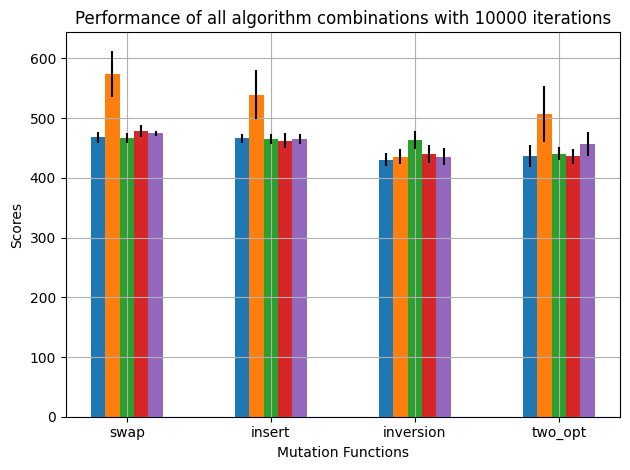

In [206]:
N_runs = 20
file = 'eil51'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [10000]
results = compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, greedy=True, fileID=fileID)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


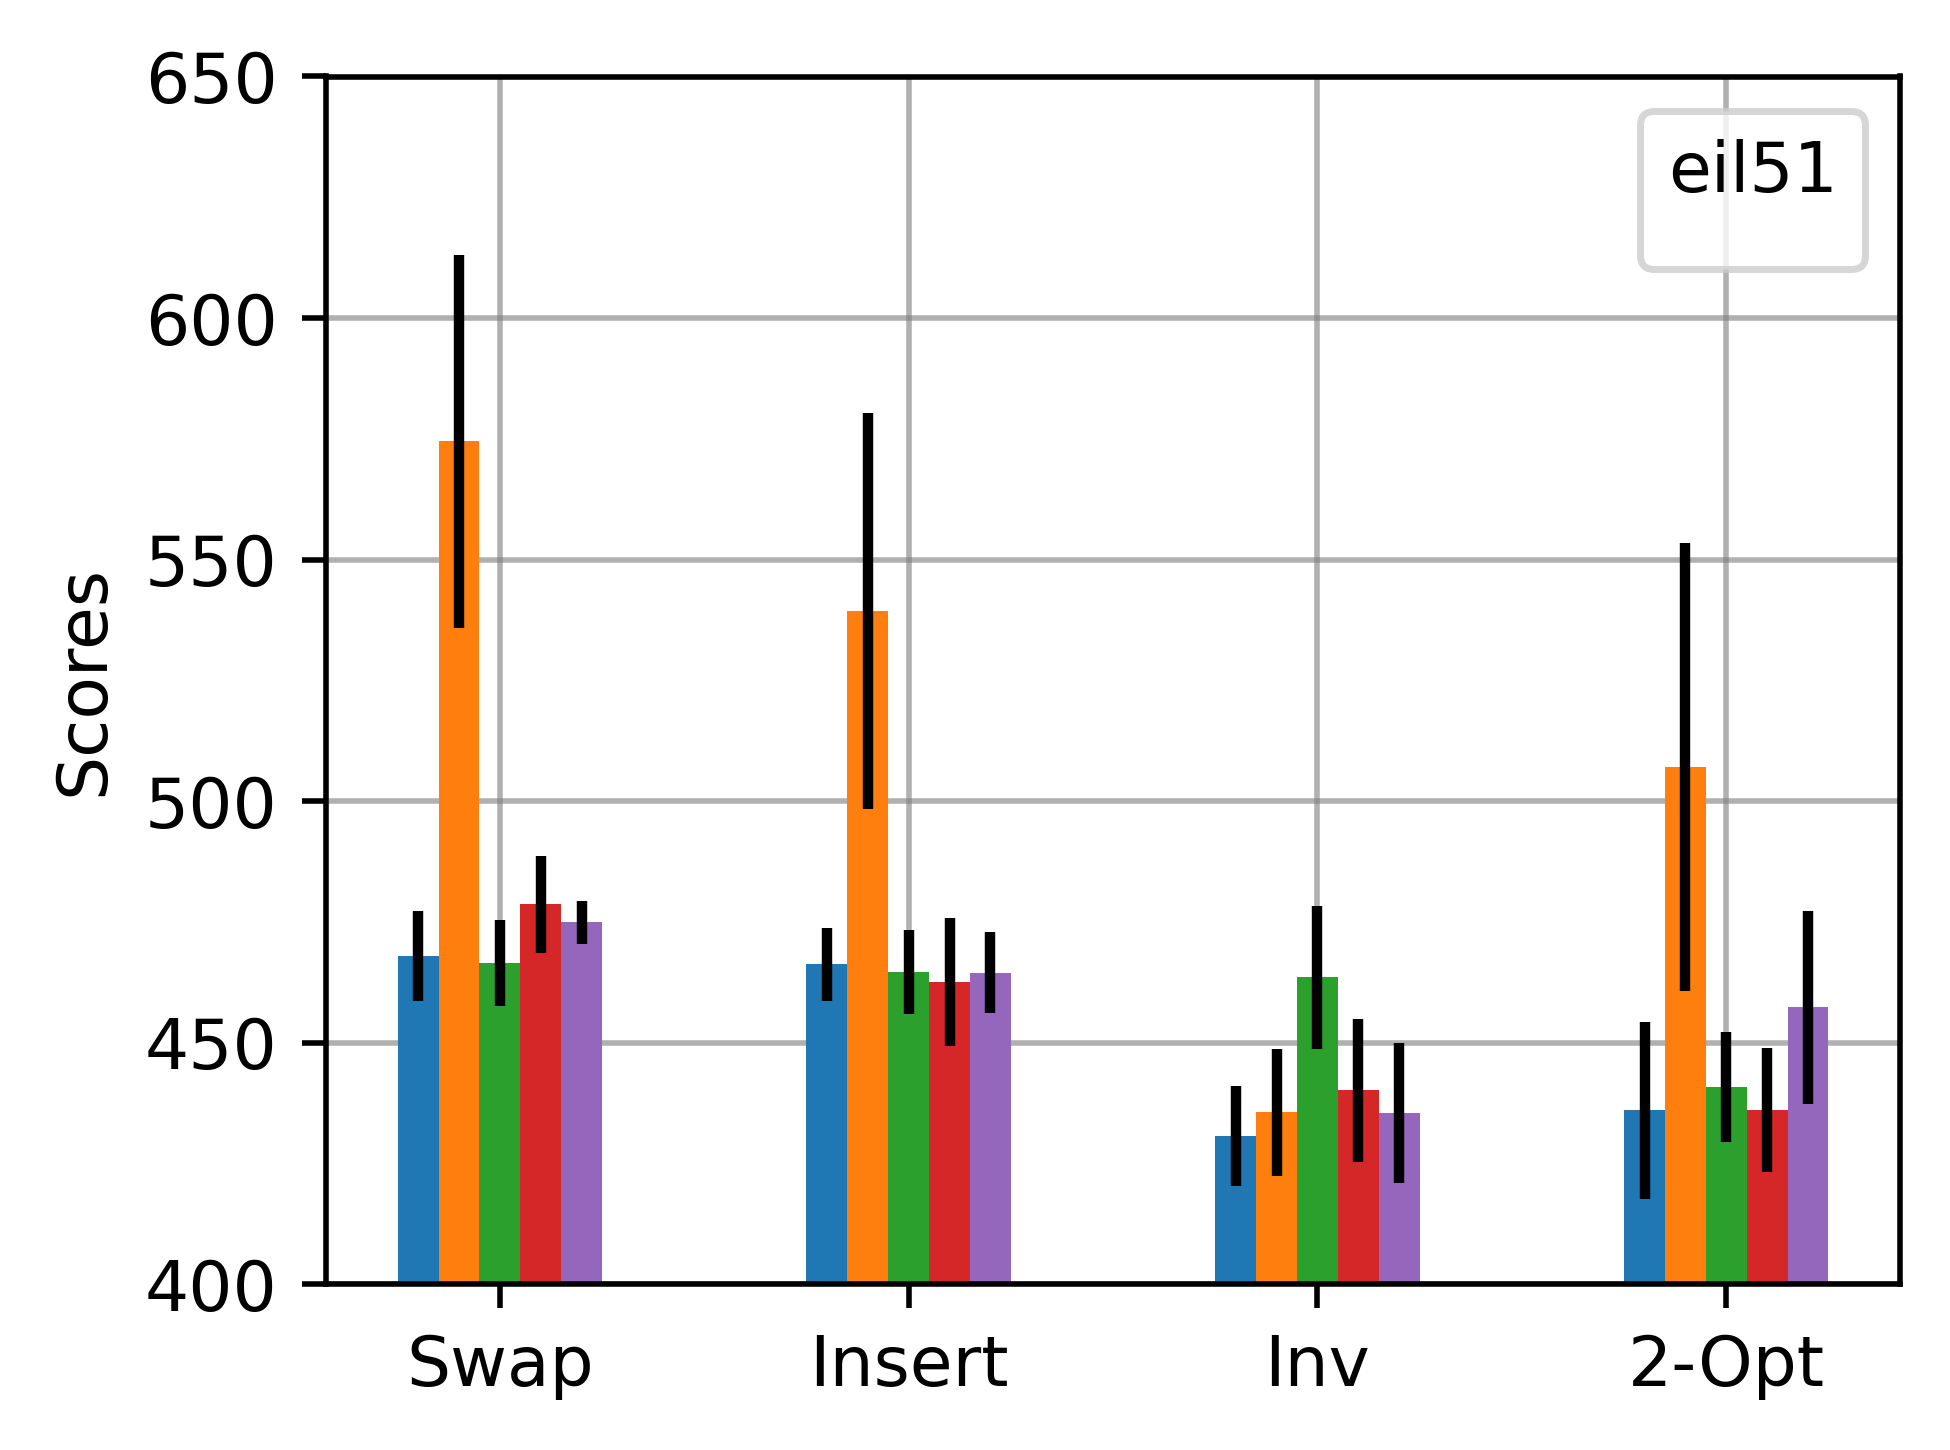

In [209]:
# Plot
# UPDATED PLOTS
plt.figure(figsize=(4,3),dpi=500)

bar_width = 0.1
bar_positions = np.arange(len(mutations))
mutation_names = [func.__name__.title() for func in mutations]
mutation_names[2] = 'inv'.title()
mutation_names[3] = '2-Opt'
cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling','Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']

res = results[0]
for i, sched in enumerate(res):
    bar_results = []
    bar_stds = []

    for data in sched['data']:
        average = data['average']
        std = data['std']
        bar_results.append(average)
        bar_stds.append(std)

    #plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, label=cooling_schemes[i], zorder=2,align='center',alpha=1)
    plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, zorder=2,align='center',alpha=1)



plt.ylabel('Scores')
plt.xticks(bar_positions + bar_width * (len(cooling_schemes) - 1) / 2, mutation_names)
plt.grid(color='gray', linestyle='-',zorder=0,alpha=0.618)
#plt.yticks(np.linspace(150000,500000,5))
plt.ylim([400,650])


plt.legend(title='eil51',loc='upper right')


plt.tight_layout()
plt.savefig('tuning_51_greedy.png')
plt.show()

C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


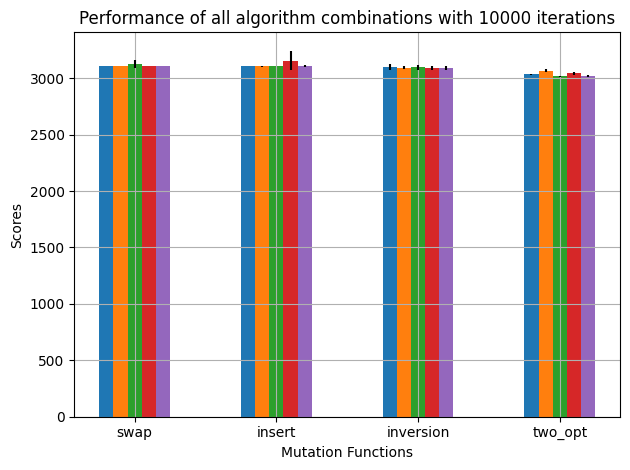

In [210]:
N_runs = 20
file = 'a280'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [10000]
results = compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, greedy=True, fileID=fileID)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


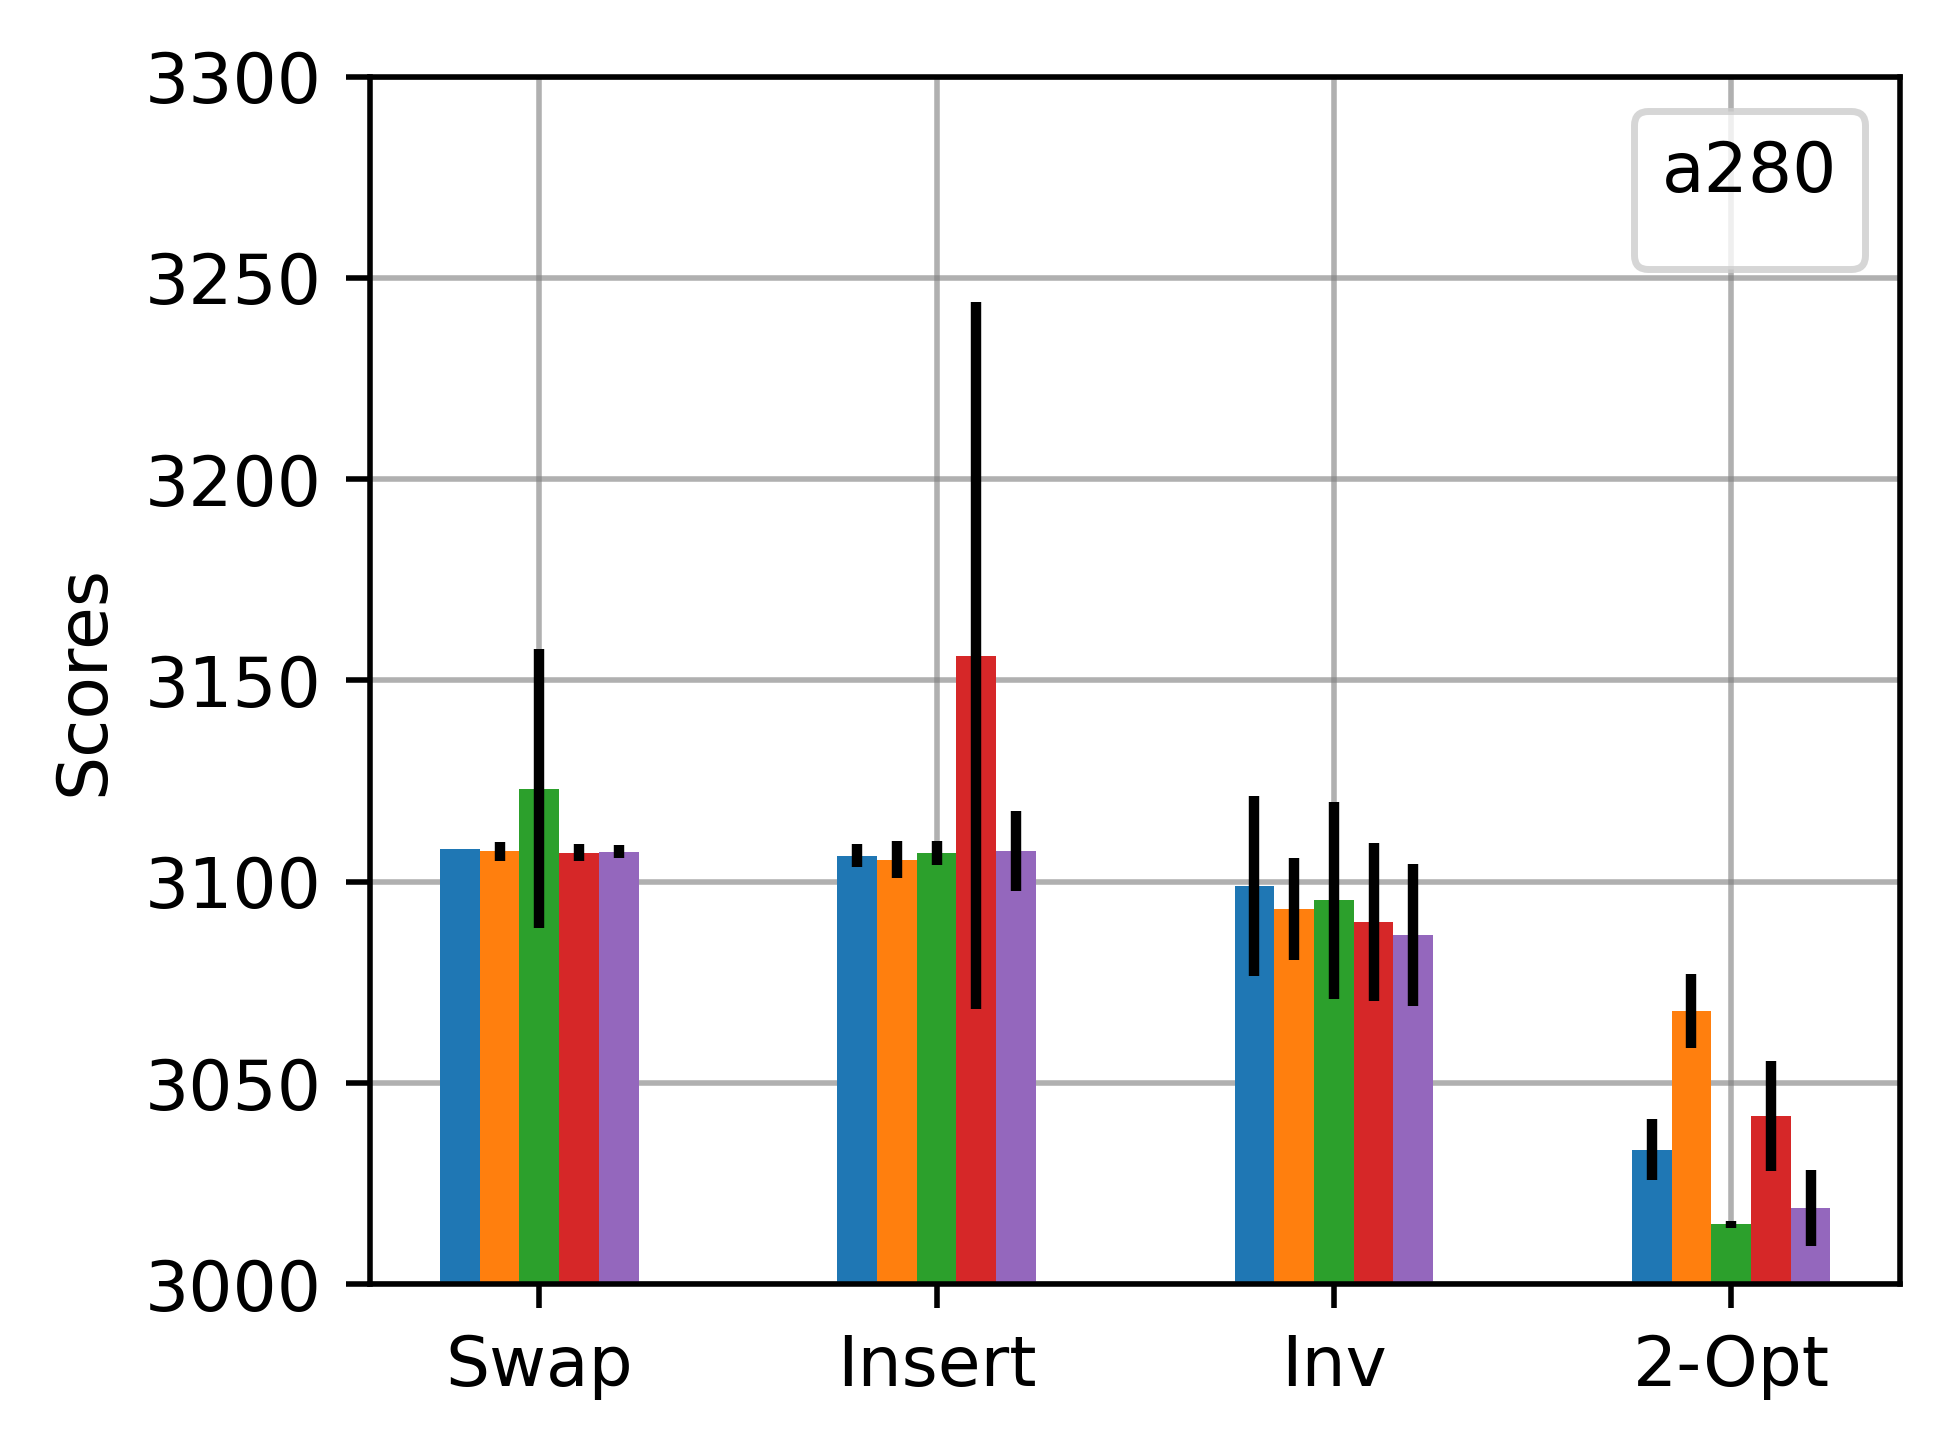

In [212]:
# Plot
# UPDATED PLOTS
plt.figure(figsize=(4,3),dpi=500)

bar_width = 0.1
bar_positions = np.arange(len(mutations))
mutation_names = [func.__name__.title() for func in mutations]
mutation_names[2] = 'inv'.title()
mutation_names[3] = '2-Opt'
cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling','Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']

res = results[0]
for i, sched in enumerate(res):
    bar_results = []
    bar_stds = []

    for data in sched['data']:
        average = data['average']
        std = data['std']
        bar_results.append(average)
        bar_stds.append(std)

    #plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, label=cooling_schemes[i], zorder=2,align='center',alpha=1)
    plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, zorder=2,align='center',alpha=1)



plt.ylabel('Scores')
plt.xticks(bar_positions + bar_width * (len(cooling_schemes) - 1) / 2, mutation_names)
plt.grid(color='gray', linestyle='-',zorder=0,alpha=0.618)
#plt.yticks(np.linspace(150000,500000,5))
plt.ylim([3000,3300])


plt.legend(title='a280',loc='upper right')


plt.tight_layout()
plt.savefig('tuning_280_greedy.png')
plt.show()

C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


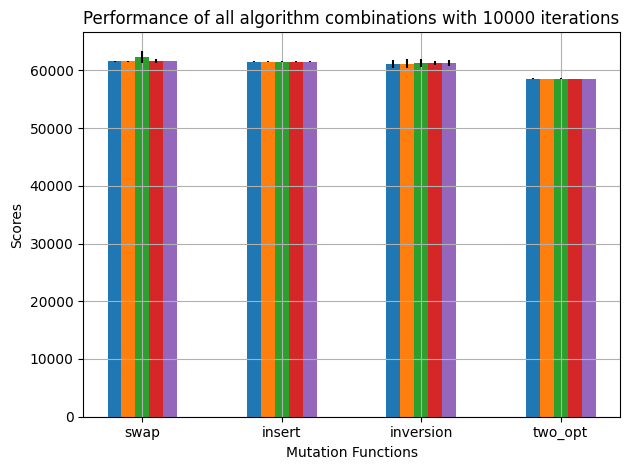

In [213]:
N_runs = 20
file = 'pcb442'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [10000]
results = compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, greedy=True, fileID=fileID)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


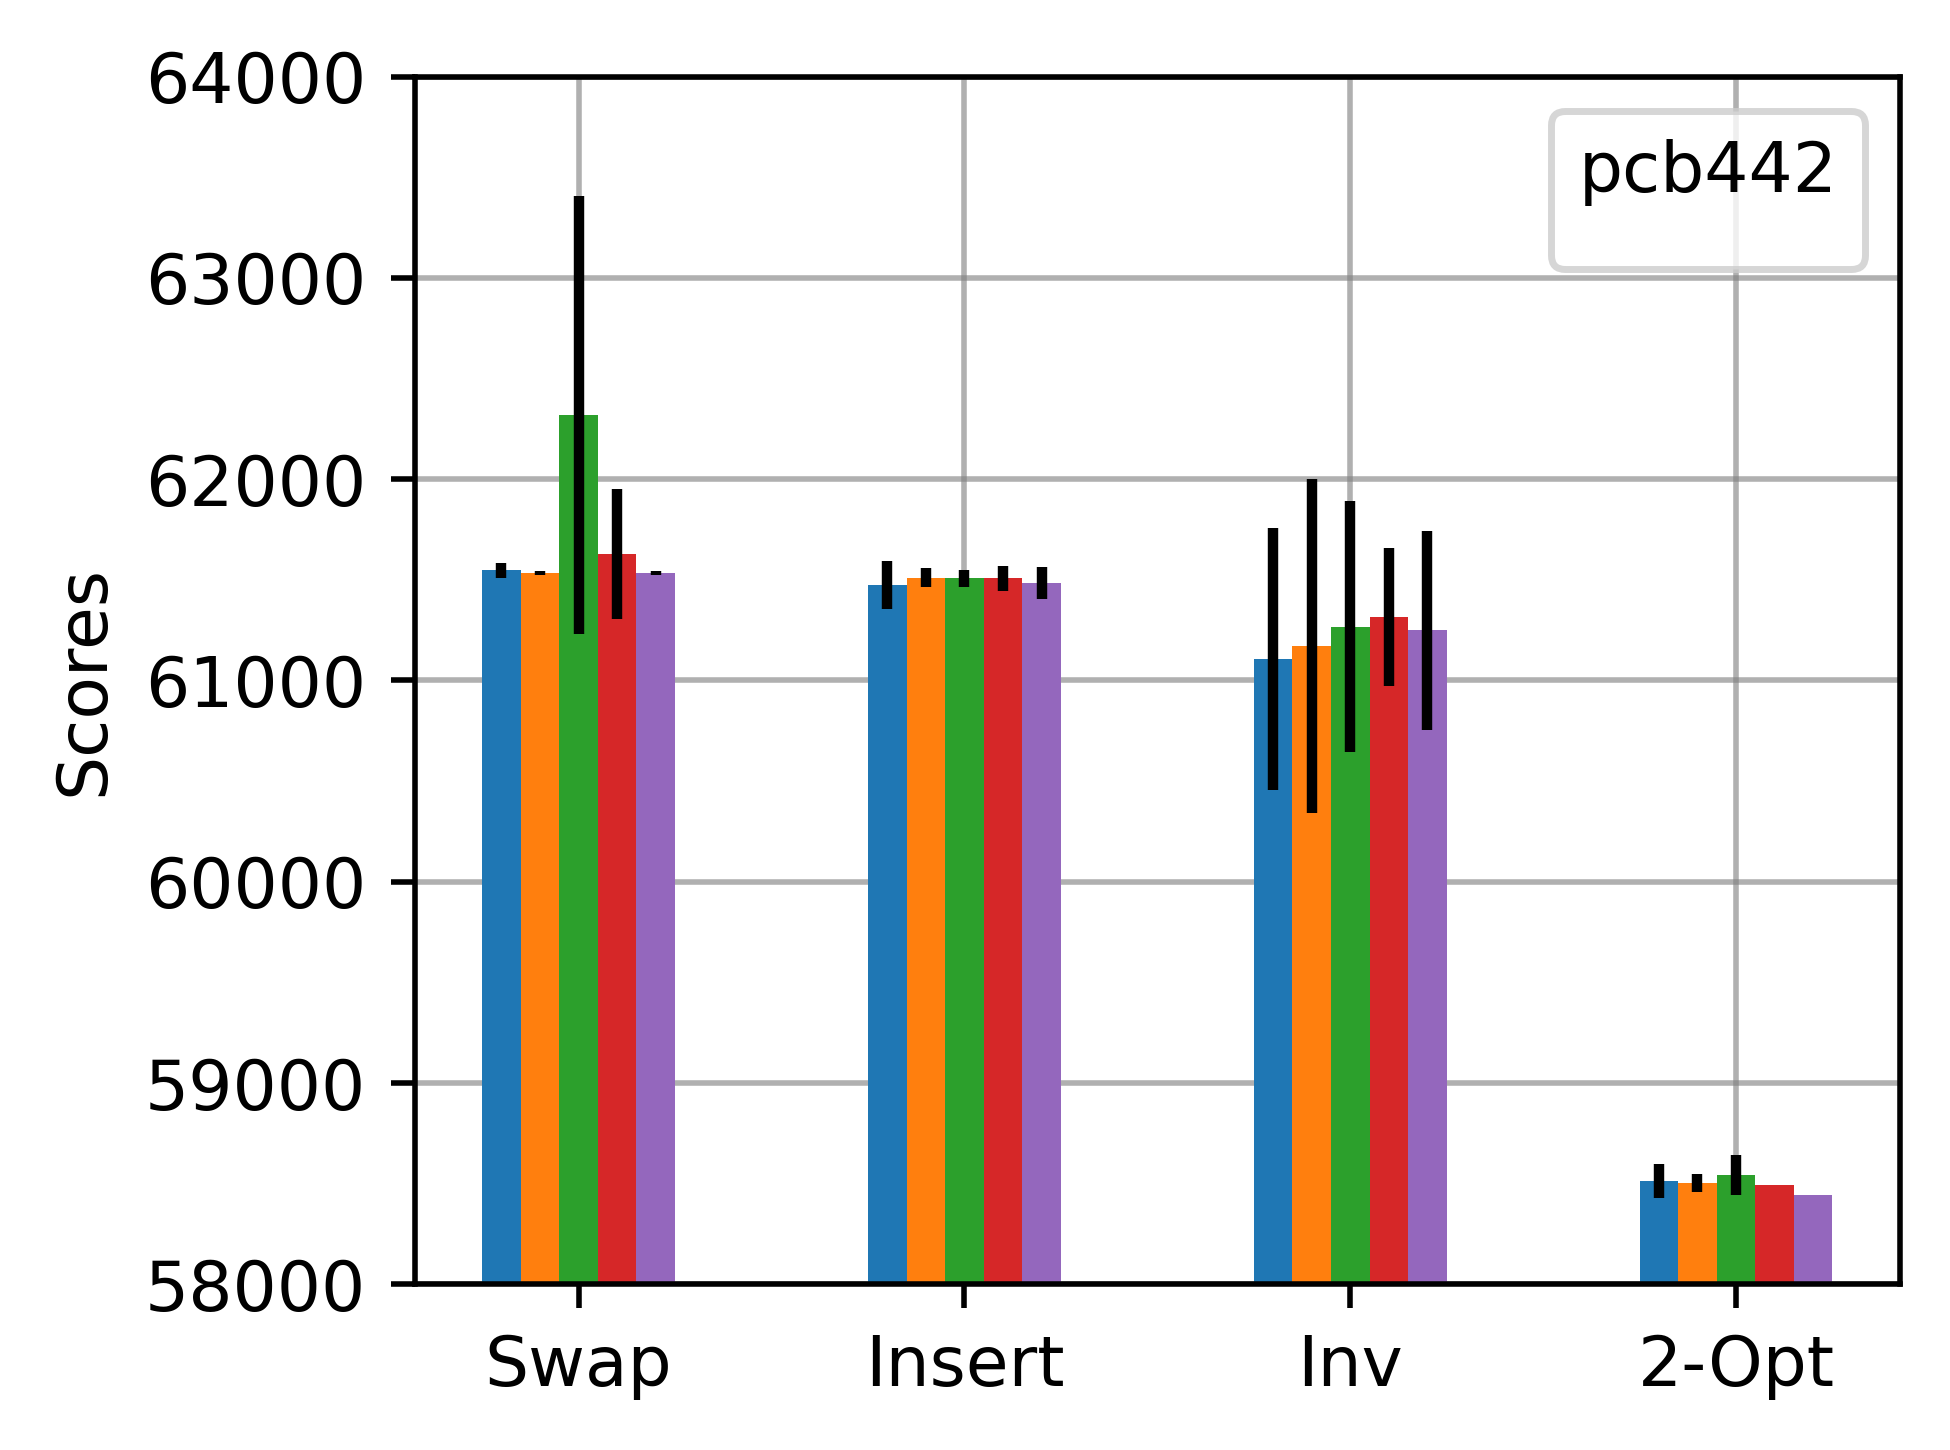

In [215]:
# Plot
# UPDATED PLOTS
plt.figure(figsize=(4,3),dpi=500)

bar_width = 0.1
bar_positions = np.arange(len(mutations))
mutation_names = [func.__name__.title() for func in mutations]
mutation_names[2] = 'inv'.title()
mutation_names[3] = '2-Opt'
cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling','Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']

res = results[0]
for i, sched in enumerate(res):
    bar_results = []
    bar_stds = []

    for data in sched['data']:
        average = data['average']
        std = data['std']
        bar_results.append(average)
        bar_stds.append(std)

    #plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, label=cooling_schemes[i], zorder=2,align='center',alpha=1)
    plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, zorder=2,align='center',alpha=1)



plt.ylabel('Scores')
plt.xticks(bar_positions + bar_width * (len(cooling_schemes) - 1) / 2, mutation_names)
plt.grid(color='gray', linestyle='-',zorder=0,alpha=0.618)
#plt.yticks(np.linspace(150000,500000,5))
plt.ylim([58000,64000])


plt.legend(title='pcb442',loc='upper right')


plt.tight_layout()
plt.savefig('tuning_442_greedy.png')
plt.show()

Now, let's see what we actually got from the tuning

In [ ]:
N_runs = 10
file='eil51'
fileID = 'random_'

mutate = inversion
cooling_schedule = arithmetic_geometric_cool

iterations = 5000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std)

Seems to perform fine, let's have a look at what the cooling actually does under the hood

In [216]:
parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')
cooling_parameters = parameters[mutate.__name__][cooling_schedule.__name__]['cooling_parameters']
investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, percentage=5, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, difference=5, logx=False, logy=False)

NameError: name 'mutate' is not defined

In [283]:
N_runs = 20
file='eil51'
fileID = 'random_'

mutate = inversion
cooling_schedule = arithmetic_geometric_cool

iterations = 10000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

scores,errors = investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std)

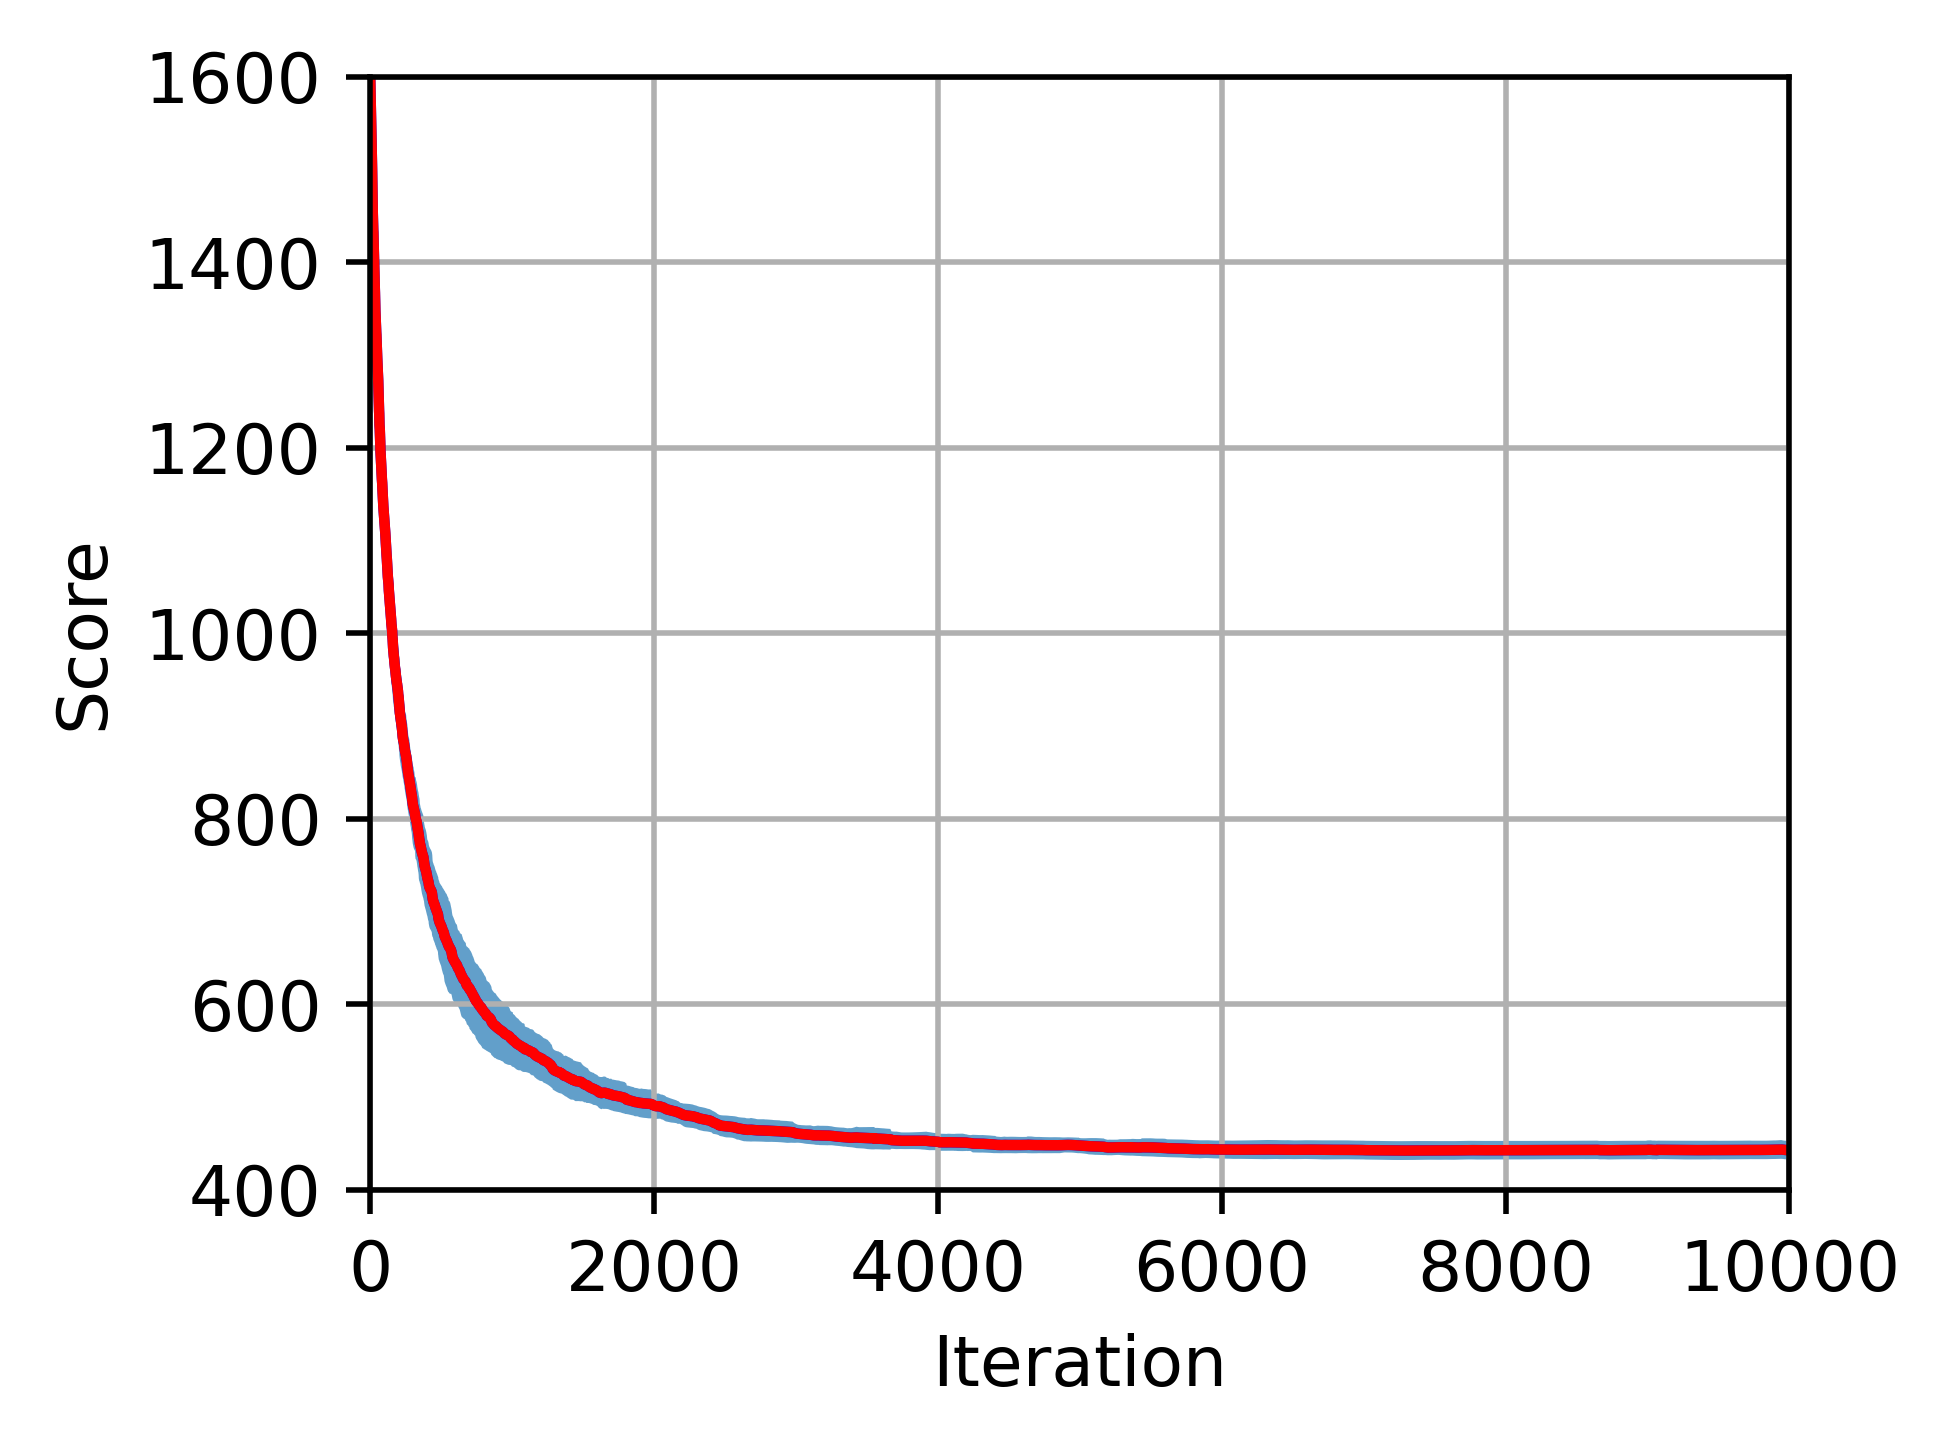

In [284]:
# Plot
plt.figure(figsize=(4,3),dpi=500)

plt.plot(np.arange(iterations), scores, linestyle='-', color='b')
plt.fill_between(np.arange(iterations), scores - errors, scores + errors, alpha=0.7)
plt.plot(np.arange(iterations), scores, linestyle='-', color='r')

plt.xlabel('Iteration')
plt.ylabel('Score')
plt.xlim([0,10000])
plt.ylim([400,1600])
plt.grid()
plt.tight_layout()

plt.savefig('score_51_random.png')
plt.show()


In [ ]:
parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')
cooling_parameters = parameters[mutate.__name__][cooling_schedule.__name__]['cooling_parameters']
investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, percentage=5, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, difference=5, logx=False, logy=False)

Weird behaviour. Maybe we can do better ourselves?

In [ ]:
cooling_parameters = {'initial': 1000,
                      'alpha': 0.998,
                      'beta': 0.005}

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, percentage=5, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, difference=5, logx=False, logy=False)

In [ ]:
investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=-1)

Not bad but still worse than what the tuning functions found to work best

In [285]:
N_runs = 10
file='a280'
fileID = 'random_'

mutate = inversion
cooling_schedule = logarithmic_cool

iterations = 10000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

scores,errors = investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std)

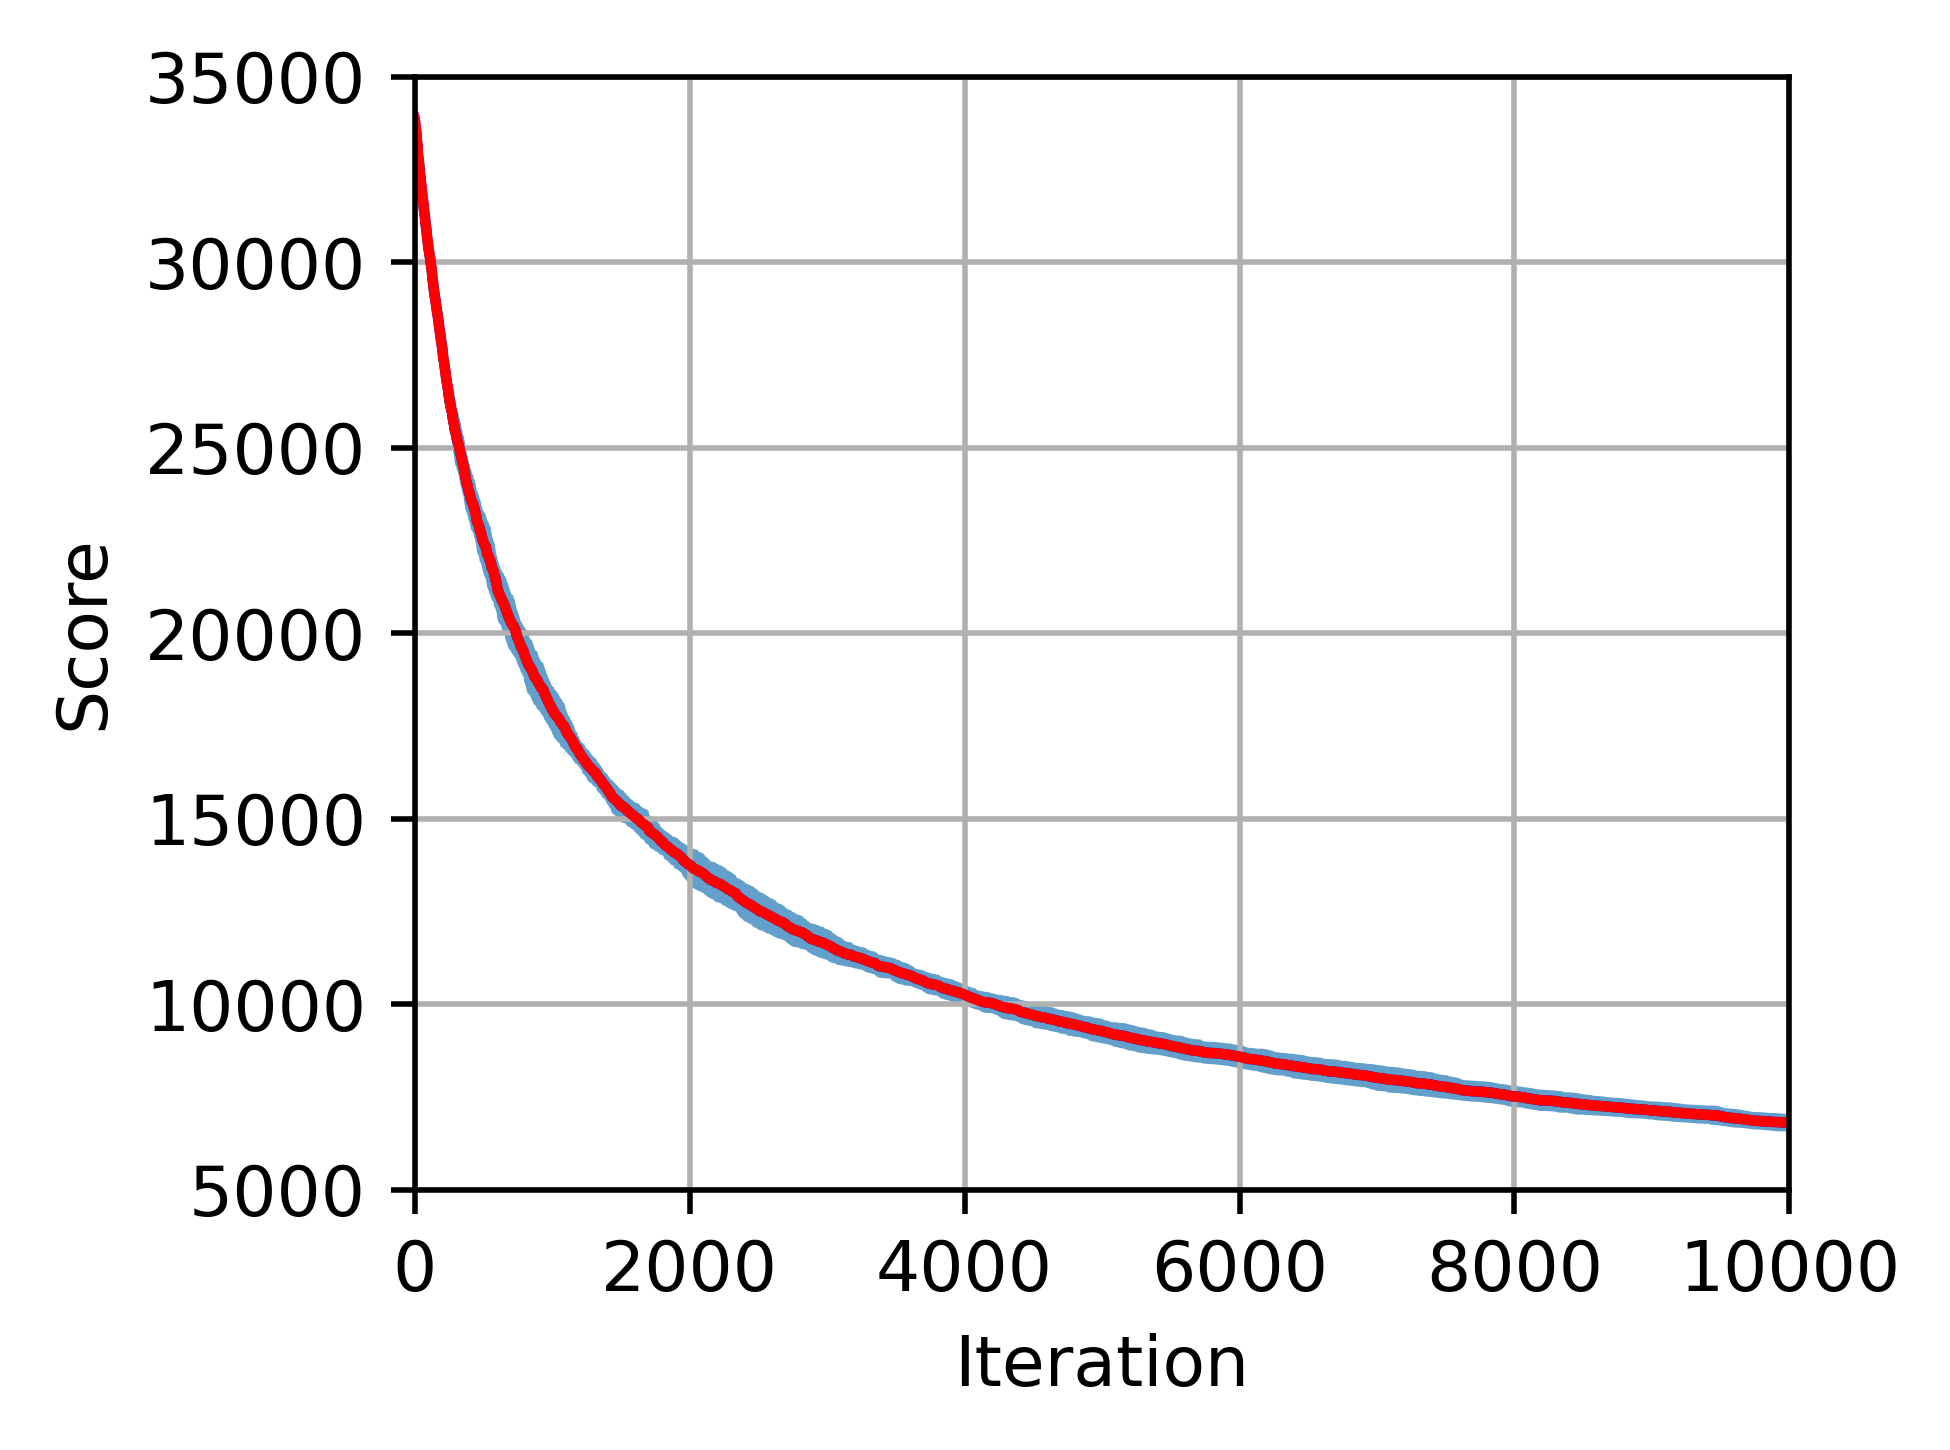

In [286]:
plt.figure(figsize=(4,3),dpi=500)

plt.plot(np.arange(iterations), scores, linestyle='-', color='b')
plt.fill_between(np.arange(iterations), scores - errors, scores + errors, alpha=0.7)
plt.plot(np.arange(iterations), scores, linestyle='-', color='r')

plt.xlabel('Iteration')
plt.ylabel('Score')
plt.xlim([0,10000])
plt.ylim([5000,35000])
plt.grid()
plt.tight_layout()

plt.savefig('score_280_random.png')
plt.show()

In [ ]:
parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')
cooling_parameters = parameters[mutate.__name__][cooling_schedule.__name__]['cooling_parameters']
investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, percentage=5, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, difference=5, logx=False, logy=False)

In [287]:
N_runs = 10
file='a280'
fileID = 'random_'

mutate = inversion
cooling_schedule = exponential_cool

iterations = 10000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

scores,errors = investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std)

C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


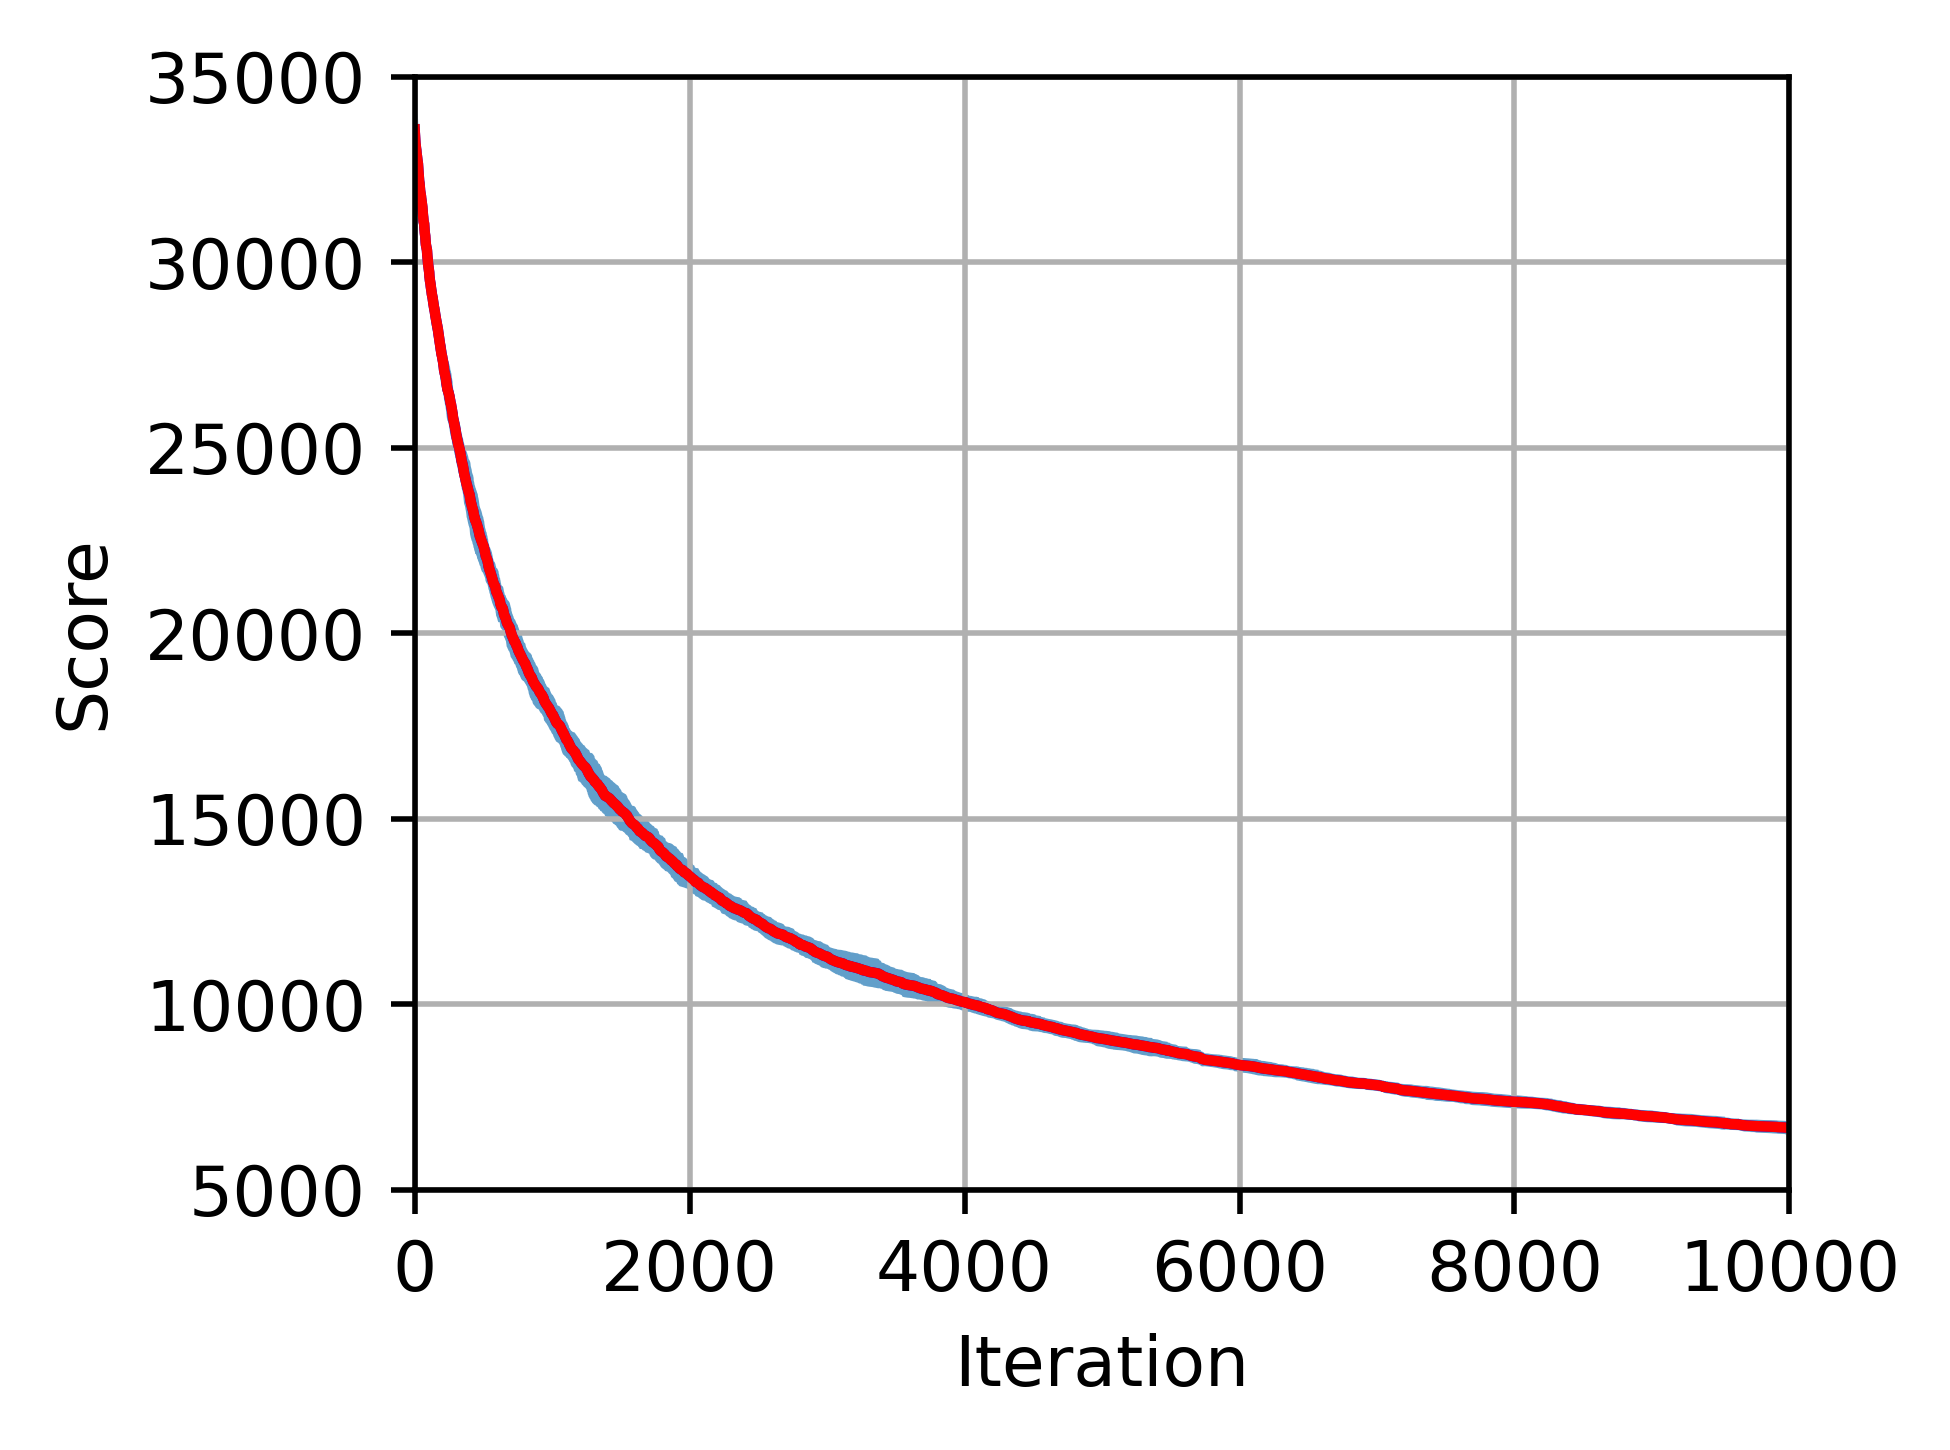

In [288]:
plt.figure(figsize=(4,3),dpi=500)

plt.plot(np.arange(iterations), scores, linestyle='-', color='b')
plt.fill_between(np.arange(iterations), scores - errors, scores + errors, alpha=0.7)
plt.plot(np.arange(iterations), scores, linestyle='-', color='r')

plt.xlabel('Iteration')
plt.ylabel('Score')
plt.xlim([0,10000])
plt.ylim([5000,35000])
plt.grid()
plt.tight_layout()

plt.savefig('score_280_random.png')
plt.show()

In [ ]:
parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')
cooling_parameters = parameters[mutate.__name__][cooling_schedule.__name__]['cooling_parameters']
investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, percentage=5, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, difference=5, logx=False, logy=False)

In [ ]:
N_runs = 10
file='pcb442'
fileID = 'random_'

mutate = inversion
cooling_schedule = logarithmic_cool

iterations = 5000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std)

In [ ]:
parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')
cooling_parameters = parameters[mutate.__name__][cooling_schedule.__name__]['cooling_parameters']
investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, percentage=5, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, difference=5, logx=False, logy=False)

In [289]:
N_runs = 10
file='pcb442'
fileID = 'random_'

mutate = inversion
cooling_schedule = quadratic_cool

iterations = 10000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

scores,errors = investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std)

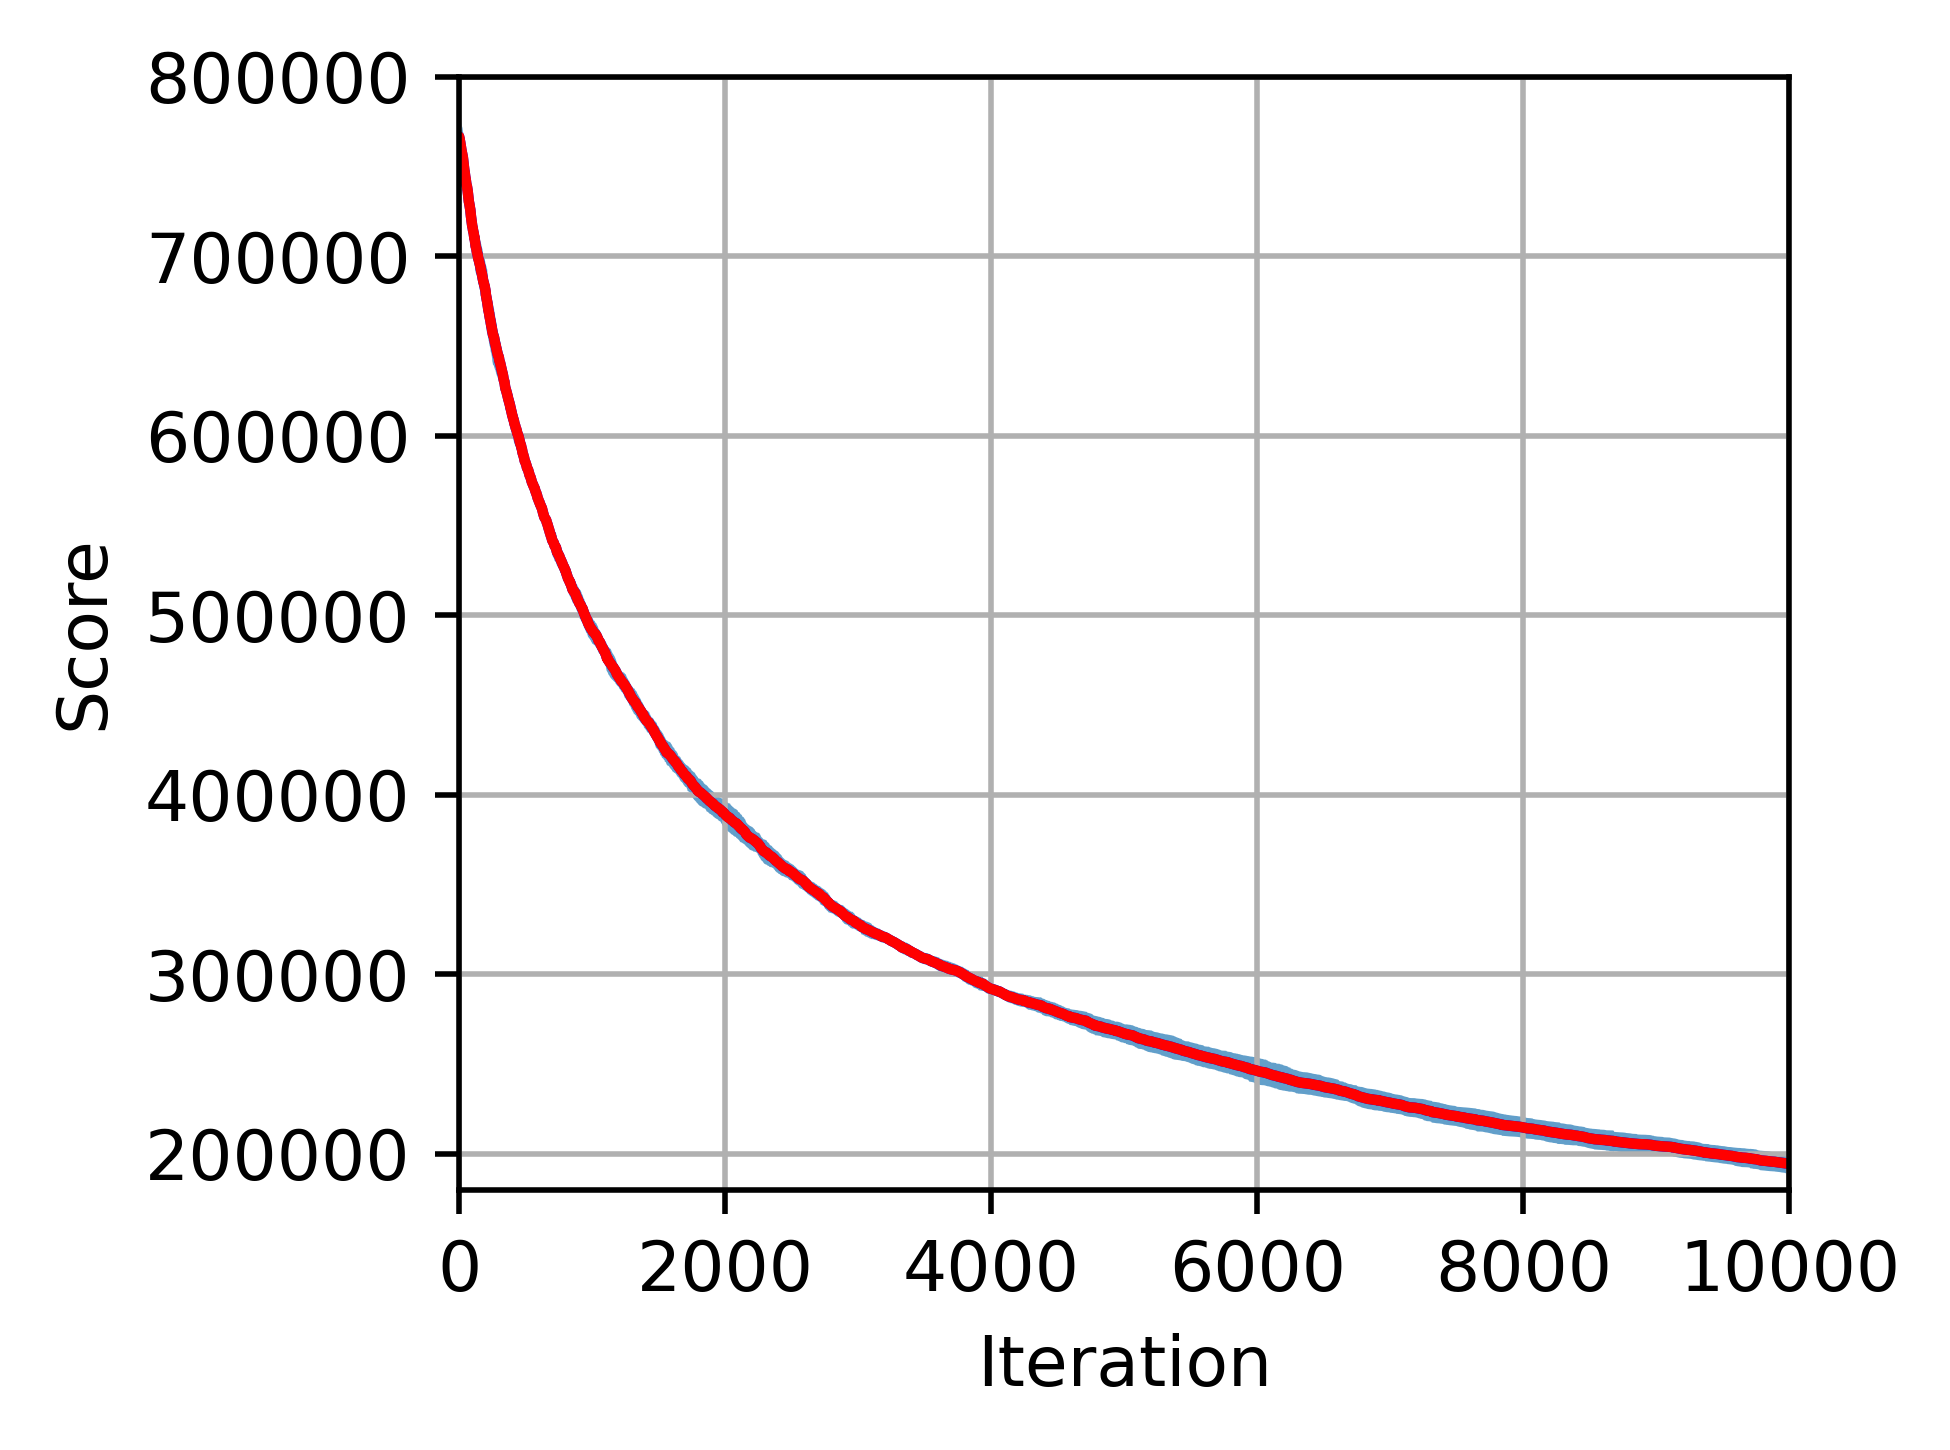

In [290]:
plt.figure(figsize=(4,3),dpi=500)

plt.plot(np.arange(iterations), scores, linestyle='-', color='b')
plt.fill_between(np.arange(iterations), scores - errors, scores + errors, alpha=0.7)
plt.plot(np.arange(iterations), scores, linestyle='-', color='r')

plt.xlabel('Iteration')
plt.ylabel('Score')
plt.xlim([0,10000])
plt.ylim([180000,800000])
plt.grid()
plt.tight_layout()

plt.savefig('score_442_random.png')
plt.show()

In [263]:
scores[-1]

194355.0576798748

In [ ]:
parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')
cooling_parameters = parameters[mutate.__name__][cooling_schedule.__name__]['cooling_parameters']
investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, percentage=5, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, difference=5, logx=False, logy=False)

Now let's do the same for greedy

In [266]:
N_runs = 10
file='eil51'
fileID = 'greedy_'

mutate = inversion
cooling_schedule = logarithmic_cool

iterations = 5000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

scores, errors = investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std, greedy=True)

In [ ]:
parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')
cooling_parameters = parameters[mutate.__name__][cooling_schedule.__name__]['cooling_parameters']
investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, percentage=5, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, difference=5, logx=False, logy=False)

In [275]:
N_runs = 20
file='eil51'
fileID = 'greedy_'

mutate = inversion
cooling_schedule = logarithmic_cool

iterations = 10000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

scores,errors = investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std, greedy=True)

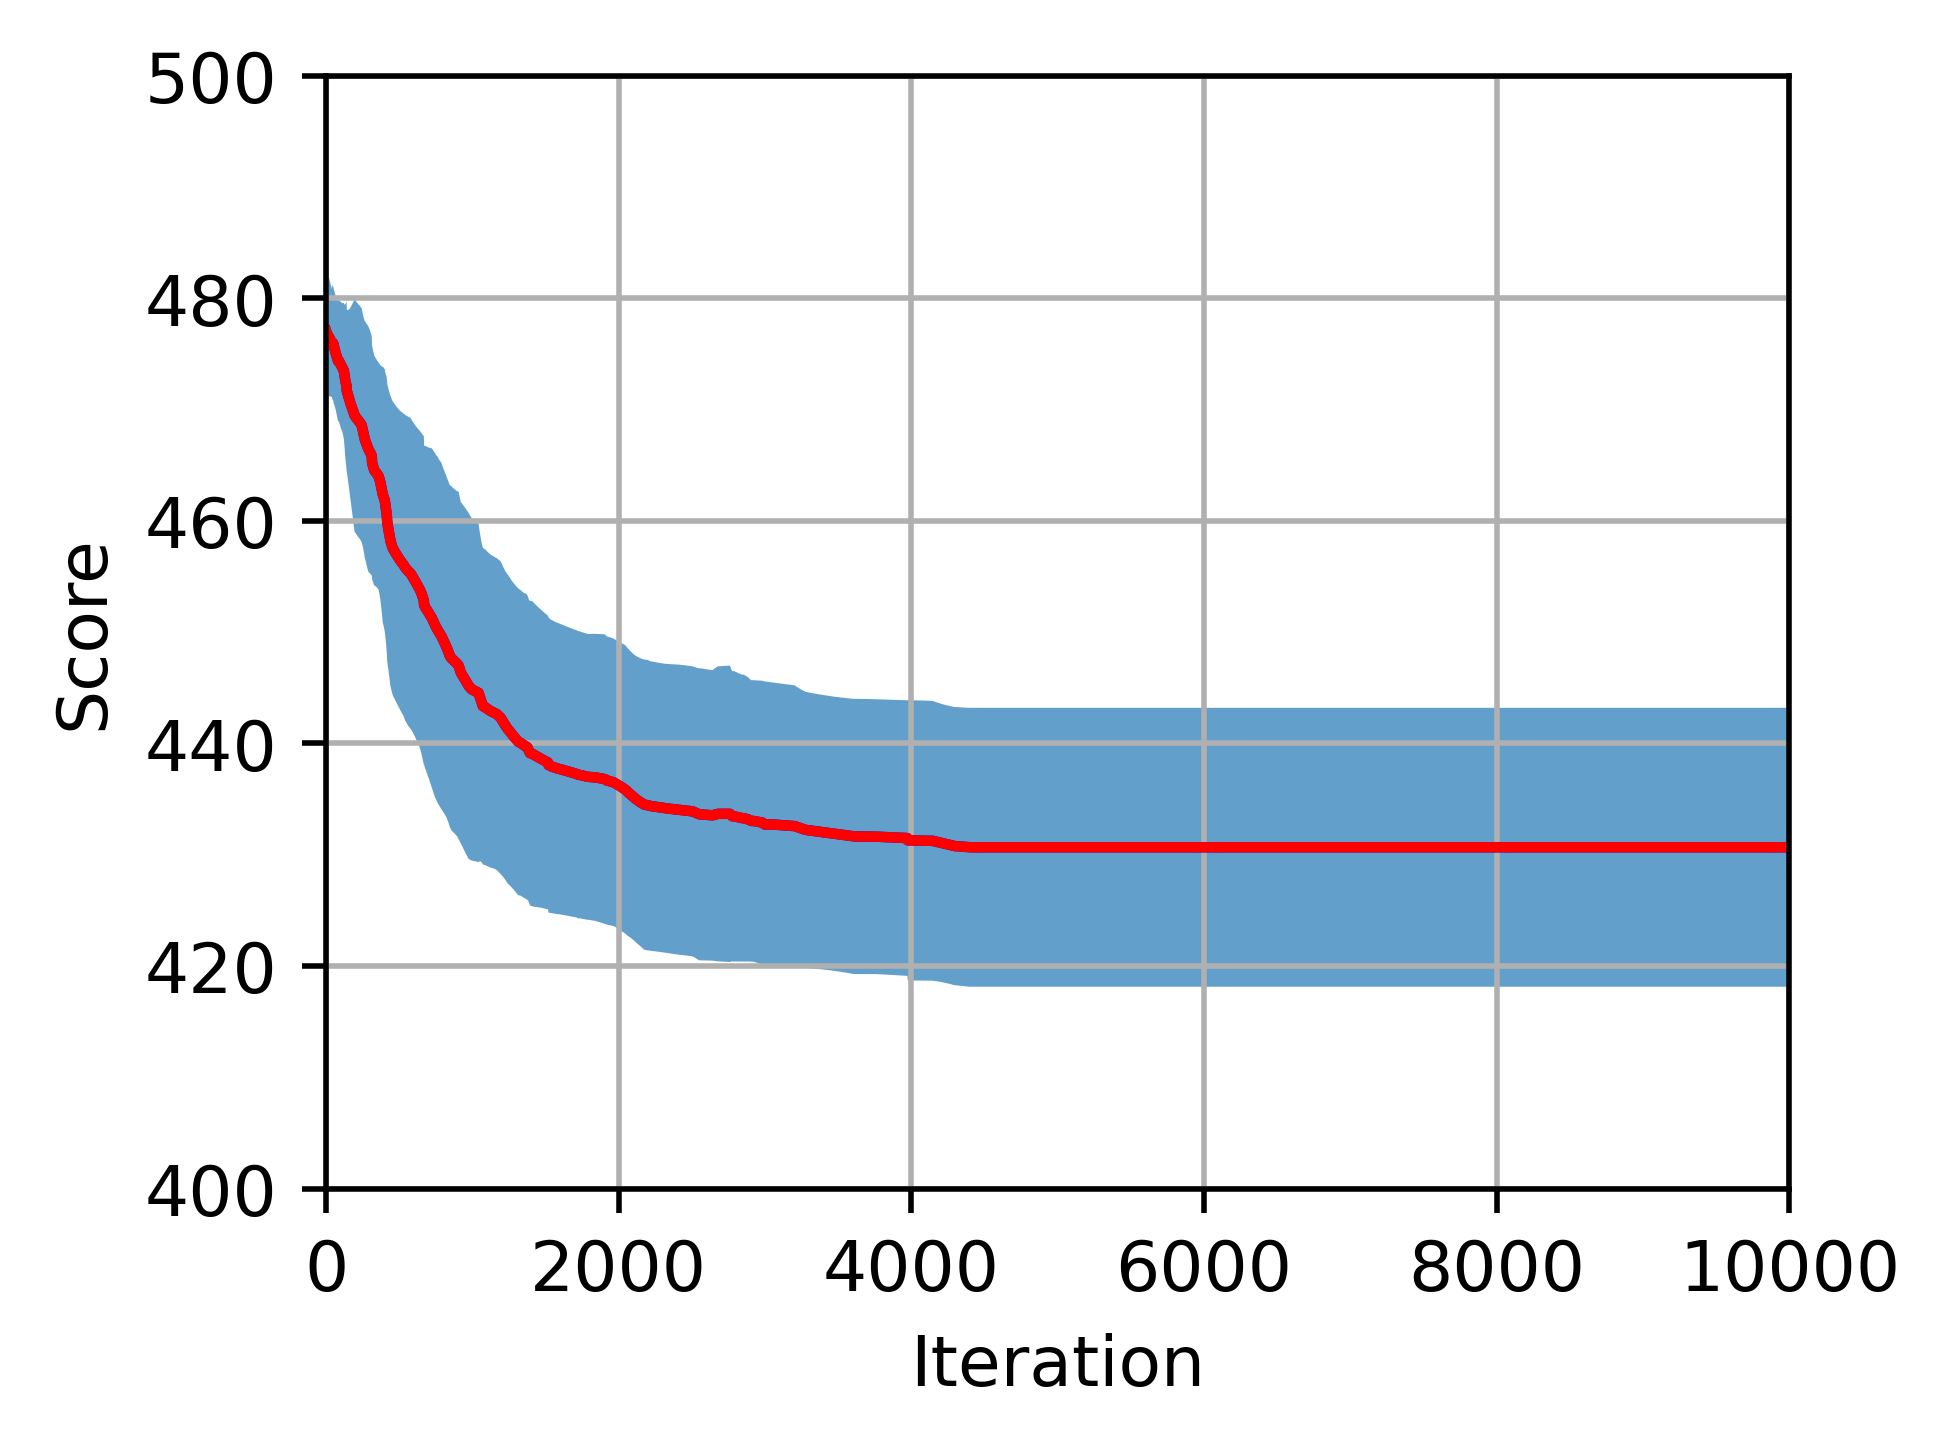

In [276]:
plt.figure(figsize=(4,3),dpi=500)

plt.plot(np.arange(iterations), scores, linestyle='-', color='b')
plt.fill_between(np.arange(iterations), scores - errors, scores + errors, alpha=0.7)
plt.plot(np.arange(iterations), scores, linestyle='-', color='r')

plt.xlabel('Iteration')
plt.ylabel('Score')
plt.xlim([0,10000])
plt.ylim([400,500])
plt.grid()
plt.tight_layout()

plt.savefig('score_51_greedy.png')
plt.show()

In [ ]:
parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')
cooling_parameters = parameters[mutate.__name__][cooling_schedule.__name__]['cooling_parameters']
investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, percentage=5, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, difference=5, logx=False, logy=False)

In [ ]:
N_runs = 10
file='a280'
fileID = 'greedy_'

mutate = inversion
cooling_schedule = exponential_cool

iterations = 5000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std, greedy=True)

In [ ]:
parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')
cooling_parameters = parameters[mutate.__name__][cooling_schedule.__name__]['cooling_parameters']
investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, percentage=5, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, difference=5, logx=False, logy=False)

In [277]:
N_runs = 20
file='a280'
fileID = 'greedy_'

mutate = two_opt
cooling_schedule = arithmetic_geometric_cool

iterations = 10000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

scores,errores = investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std, greedy=True)

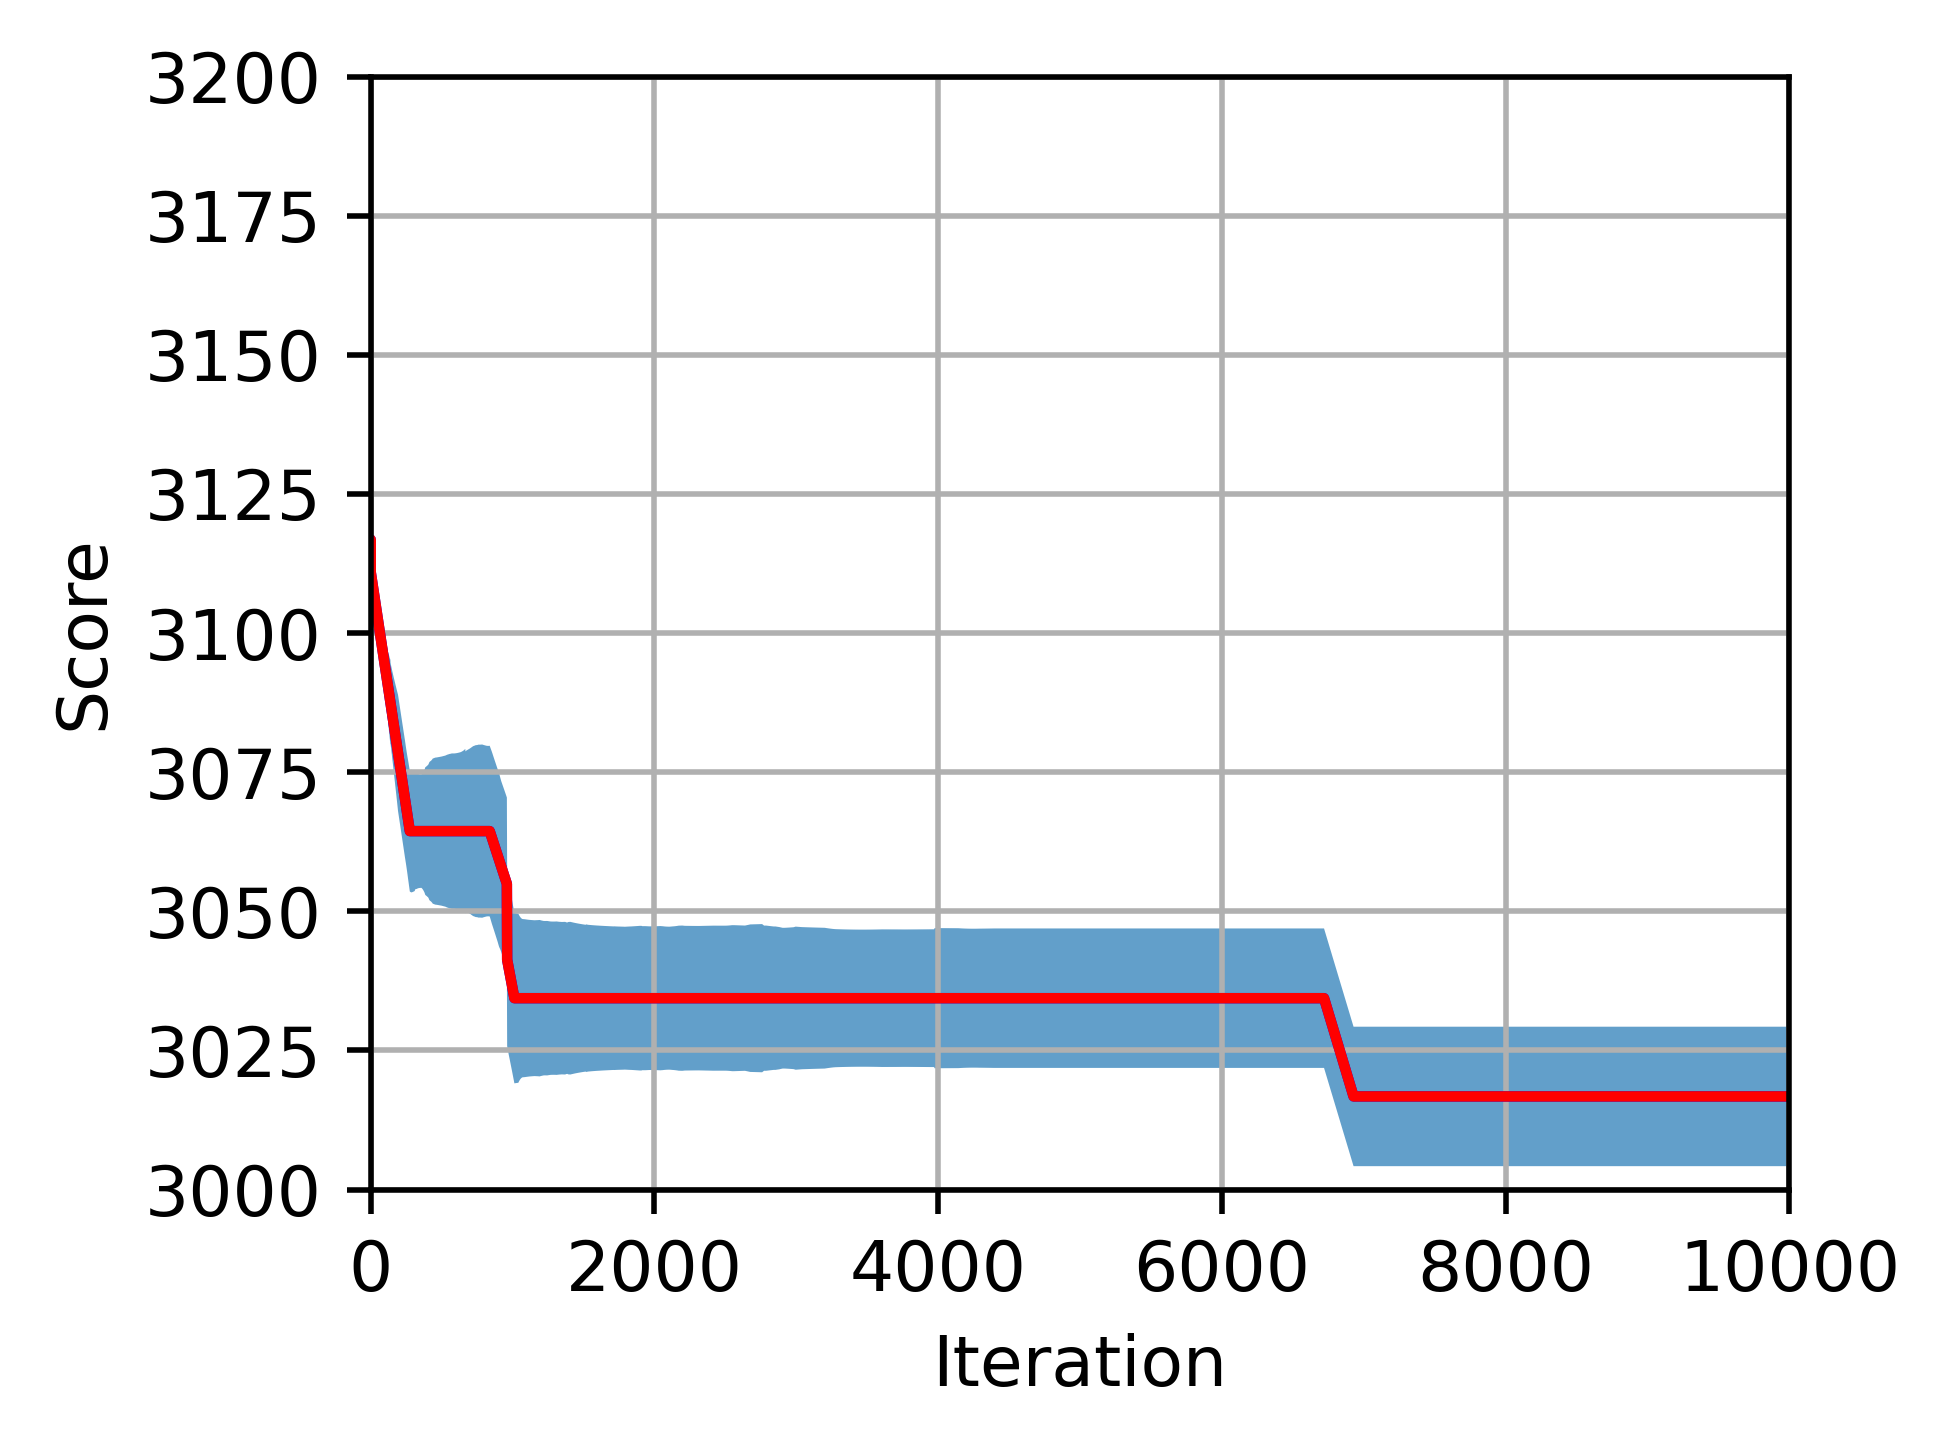

In [278]:
plt.figure(figsize=(4,3),dpi=500)

plt.plot(np.arange(iterations), scores, linestyle='-', color='b')
plt.fill_between(np.arange(iterations), scores - errors, scores + errors, alpha=0.7)
plt.plot(np.arange(iterations), scores, linestyle='-', color='r')

plt.xlabel('Iteration')
plt.ylabel('Score')
plt.xlim([0,10000])
plt.ylim([3000,3200])
plt.grid()
plt.tight_layout()

plt.savefig('score_280_greedy.png')
plt.show()

In [ ]:
parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')
cooling_parameters = parameters[mutate.__name__][cooling_schedule.__name__]['cooling_parameters']
investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, percentage=5, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, difference=5, logx=False, logy=False)

In [ ]:
N_runs = 10
file='pcb442'
fileID = 'greedy_'

mutate = two_opt
cooling_schedule = arithmetic_geometric_cool

iterations = 5000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std, greedy=True)

In [ ]:
parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')
cooling_parameters = parameters[mutate.__name__][cooling_schedule.__name__]['cooling_parameters']
investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, percentage=5, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, difference=5, logx=False, logy=False)

In [279]:
N_runs = 20
file='pcb442'
fileID = 'greedy_'

mutate = two_opt
cooling_schedule = exponential_cool

iterations = 10000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

scores, errores = investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std, greedy=True)

C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\Pablo\AppData\Local\Temp\ipykernel_8968\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


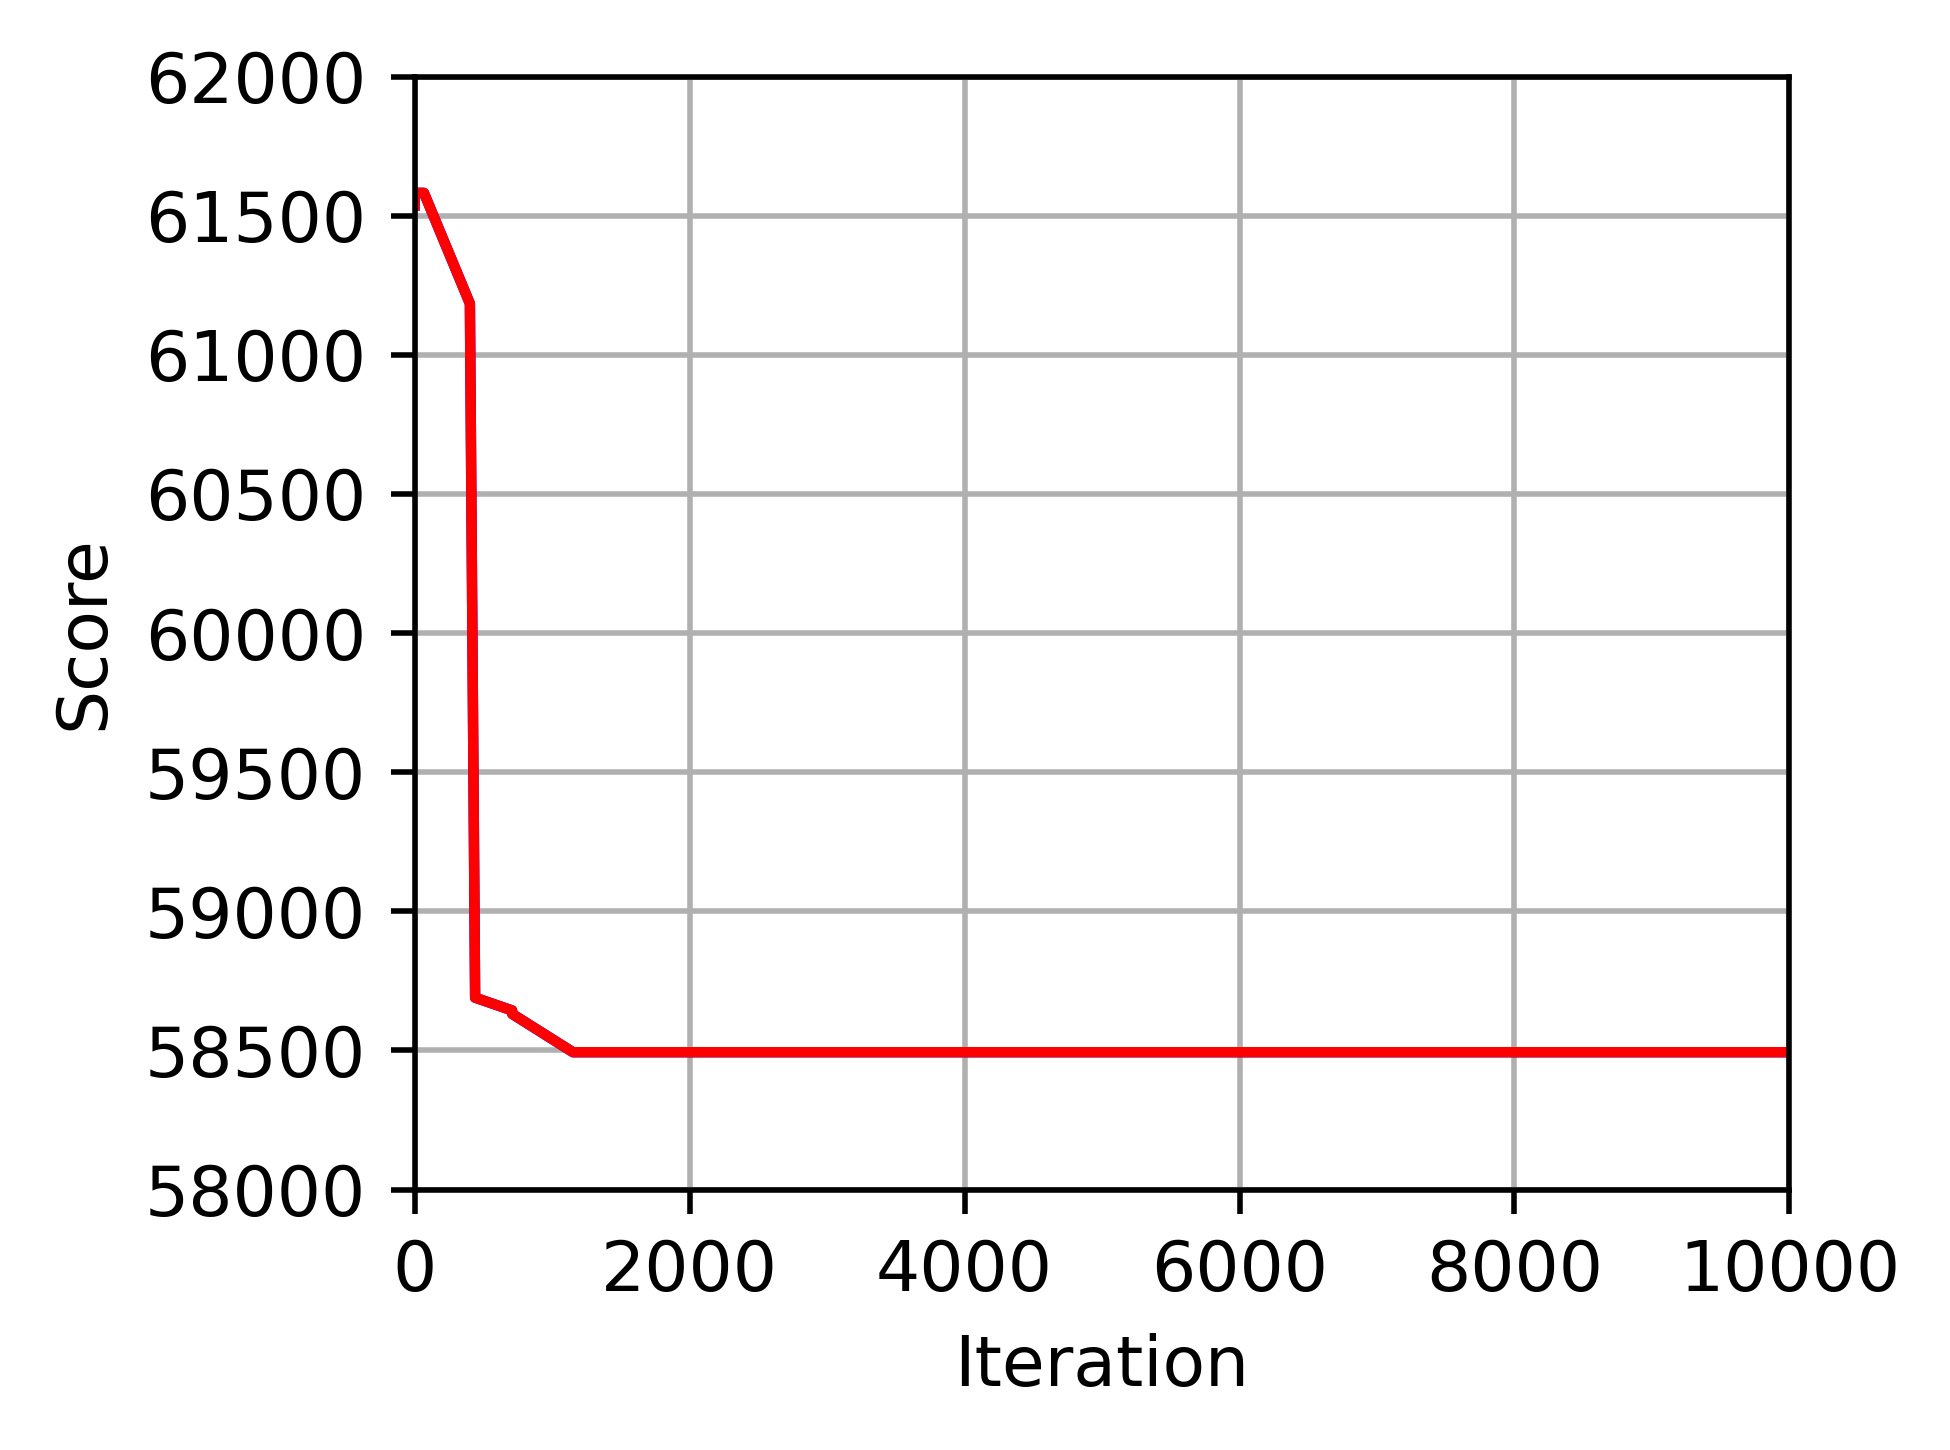

In [282]:
plt.figure(figsize=(4,3),dpi=500)

plt.plot(np.arange(iterations), scores, linestyle='-', color='b')
plt.fill_between(np.arange(iterations), scores - errors, scores + errors, alpha=0.7)
plt.plot(np.arange(iterations), scores, linestyle='-', color='r')

plt.xlabel('Iteration')
plt.ylabel('Score')
plt.xlim([0,10000])
plt.ylim([58000,62000])
plt.grid()
plt.tight_layout()

plt.savefig('score_442_greedy.png')
plt.show()

In [ ]:
parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')
cooling_parameters = parameters[mutate.__name__][cooling_schedule.__name__]['cooling_parameters']
investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, percentage=5, logx=False, logy=False)

investigate_cooling(iterations, cooling_schedule, cooling_parameters, cooling_schedule.__name__, difference=5, logx=False, logy=False)

So, it appears that greedy performs better than random initialization, and that for bigger problems, two_opt starts to outperform inversion. 


Besides, for nearly all best found set of parameters and algorithms to solve a city, the temperature goes to 0 very quickly. Hence, we can re-use those algorithms if we want to have more iterations, the results of tuning would most probably again result in very rapidly decreasing temperature for more iterations.